<h1 align="center"> Customer Churn Prediction </h1>

**Note:** This is the real Malaysia Insurance Dataset representing the customers with claim records from 2018-2021. The actual size of the customer base, including those with no claim, is way bigger.


<h2> Introduction </h2>

In this kernel we will use various predictive models to see how accurate they are in predicting whether a customer is churn or not. As for the dataset, the names of the features are not shown due to privacy reasons. The columns with 'C' prefix stands for categorical data whereas 'N' prefix for numerical data. However, we can still analyze some important aspects of the dataset. Let's start!

<h2> Our Goals: </h2>
<ul>
<li> Comparison between different models. </li>
<li> Select the best model to predict Churn Customers. </li>
<li> Precision will be our main evaluation metric. </li>
</ul>



## Index:
### 1. Import libraries and load data
### 2. Exploratory Data Analysis (EDA)
#### 2.1 EDA on numerical data
#### 2.2 EDA on categorical data
### 3. Data Preprocessing
#### 3.1 Duplicates
#### 3.2 Cardinality
#### 3.3 Correlation
#### 3.4 Missing values
#### 3.5 Outliers
#### 3.6 Chi-square test
### 4. Modeling
#### 4.1 LightGBM
#### 4.2 XGBoost
#### 4.3 Testing Model Robustness With Jitter
#### 4.4 Model Analysis

# 1. Import libraries and load data

In [1]:
#Data preprocessing
import numpy as np
import pandas as pd
from scipy import stats


#Visualization
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import plotly
import plotly.express as px 
import plotly.io as pio 
import plotly.offline as py
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import matplotlib.patches as mpatches
from IPython.display import Markdown
from matplotlib.pyplot import figure
#plt.style.use('fivethirtyeight')

#Modelling
import featurewiz as FW
from sklego.meta import Thresholder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import ClusterCentroids
from yellowbrick.classifier import DiscriminationThreshold
from optuna.integration import LightGBMPruningCallback
from optuna.integration import XGBoostPruningCallback
import optuna  # pip install optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, average_precision_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score

#Other
import warnings
import time
warnings.simplefilter(action='ignore')

C:\Users\septe\AppData\Roaming\Python\Python39\site-packages\xgboost\compat.py:31: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Imported version = 0.1.83.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                


In [2]:
df_full = pd.read_csv('Insurance dataset (Malaysia).csv')
df = df_full.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57381 entries, 0 to 57380
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C1      57381 non-null  int64  
 1   C2      57381 non-null  int64  
 2   C3      57381 non-null  int64  
 3   C4      57381 non-null  int64  
 4   C5      57381 non-null  int64  
 5   C6      57381 non-null  int64  
 6   N1      57381 non-null  float64
 7   C7      57381 non-null  int64  
 8   N2      57381 non-null  int64  
 9   C8      57381 non-null  int64  
 10  C9      57381 non-null  int64  
 11  C10     57381 non-null  int64  
 12  C11     57381 non-null  int64  
 13  C12     57381 non-null  int64  
 14  C13     57381 non-null  int64  
 15  N3      57381 non-null  int64  
 16  N4      57381 non-null  int64  
 17  Churn   57381 non-null  bool   
dtypes: bool(1), float64(1), int64(16)
memory usage: 7.5 MB


In [4]:
df.head()

C1  C2  C3  C4  C5  C6    N1  C7  N2  C8  C9  C10  C11  C12  C13  N3  N4  \
0   1   2   2   1   1   1  23.0   1  45   1   5    1    1    1    1  69  26   
1   2   2   2   3   1   1  16.0   1  28   1   5    1    1    1    1  85   5   
2   1   1   2   1   2   2  23.1   1  49   2   1    2    2    1    2  28  47   
3   1   1   2   2   3   1  15.4   1  58   2   1    2    2    1    2  78   2   
4   1   2   1   1   2   1  23.0   1  43   1   5    2    3    1    1  27  43   

   Churn  
0  False  
1  False  
2  False  
3  False  
4  False

In [5]:
df.shape

(57381, 18)

# 2. Exploratory Data Analysis (EDA)

In [6]:
num_col = []
cat_col = []

for x in df.columns:
    if x.startswith('C'):
        if x != 'Churn':
            cat_col.append(x)
    else:
        num_col.append(x)

In [7]:
def target_dis(df):
    y = np.array([len(df.loc[(df['Churn'] == 1)]), len(df.loc[(df['Churn'] == 0)])])
    mylabels = ["Churn", "Not Churn"]

    plt.figure(figsize=(6,4), dpi=100)
    plt.title('Distribution of Target (Churn)')
    plt.pie(y, labels = mylabels, autopct='%.2f%%', colors = ['#DD7596', '#8EB897'])
    plt.show()

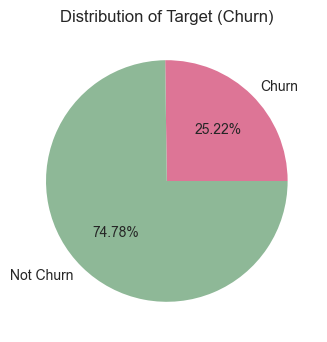

In [8]:
target_dis(df)

**Note:** This is the data of customers with claim records only. The actual size of the customer base (claim & without claim) is way larger.

**Distributions:** This is an imbalanced dataset which makes sense in real life. Most of the policy holders are not-churn.

**Reminder:** Avoid using Accuracy as the metric for model evaluation. F1-score, Recall and Precision will be the better choices depending on the business needs. 

## 2.1 EDA on Numerical data

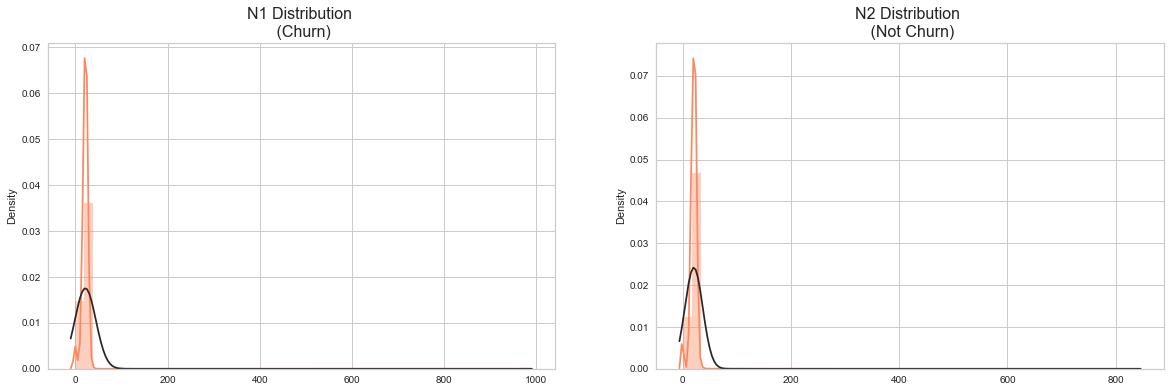

In [9]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

N1_churn = df['N1'].loc[df['Churn'] == 1].values
sns.distplot(N1_churn,ax=ax1, fit=norm, color='#fB8861')
ax1.set_title('N1 Distribution \n (Churn)', fontsize=16)

N1_not_churn = df['N1'].loc[df['Churn'] == 0].values
sns.distplot(N1_not_churn,ax=ax2, fit=norm, color='#fB8861')
ax2.set_title('N2 Distribution \n (Not Churn)', fontsize=16)

plt.show()

**Distributions (N1):** By seeing the distributions we can know that extreme outliers exist in the N1 feature. I personally know the feature name of this N1 and its acceptance range. All the outliers belong to data entry errors.

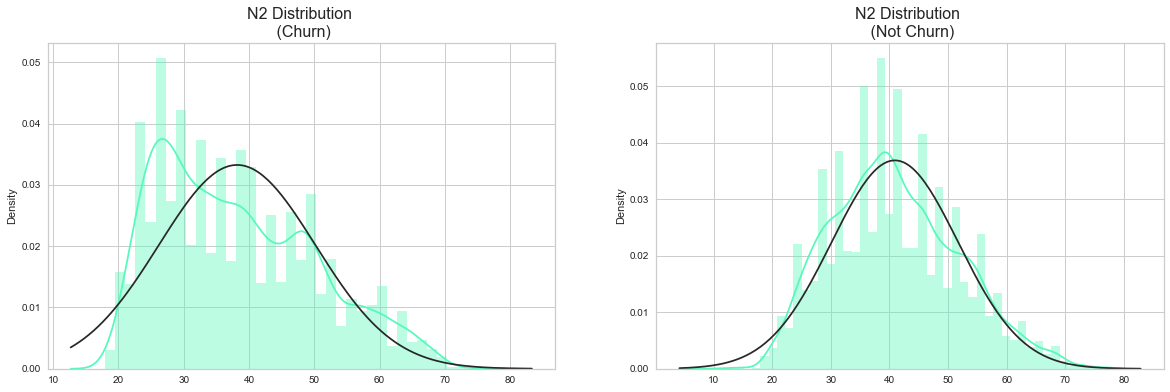

In [10]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

N2_churn = df['N2'].loc[df['Churn'] == 1].values
sns.distplot(N2_churn,ax=ax1, fit=norm, color='#56f9bb')
ax1.set_title('N2 Distribution \n (Churn)', fontsize=16)

N2_not_churn = df['N2'].loc[df['Churn'] == 0].values
sns.distplot(N2_not_churn,ax=ax2, fit=norm, color='#56f9bb')
ax2.set_title('N2 Distribution \n (Not Churn)', fontsize=16)

plt.show()

**Distributions (N2):** The distribution for N2 (Churn) is slightly skew to the right whereas N2 (Not Churn) showed ~ normal distribution characteristic

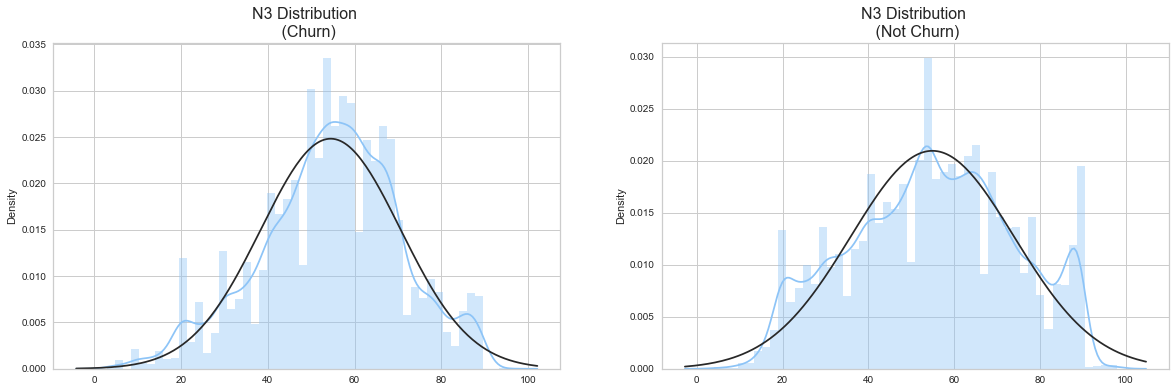

In [11]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

N3_churn = df['N3'].loc[df['Churn'] == 1].values
sns.distplot(N3_churn,ax=ax1, fit=norm, color='#8dc4f7')
ax1.set_title('N3 Distribution \n (Churn)', fontsize=16)

N3_not_churn = df['N3'].loc[df['Churn'] == 0].values
sns.distplot(N3_not_churn,ax=ax2, fit=norm, color='#8dc4f7')
ax2.set_title('N3 Distribution \n (Not Churn)', fontsize=16)

plt.show()

**Distributions (N3):** Both distributions for N3 (Churn and Not Churn) show ~ normal distribution characteristic

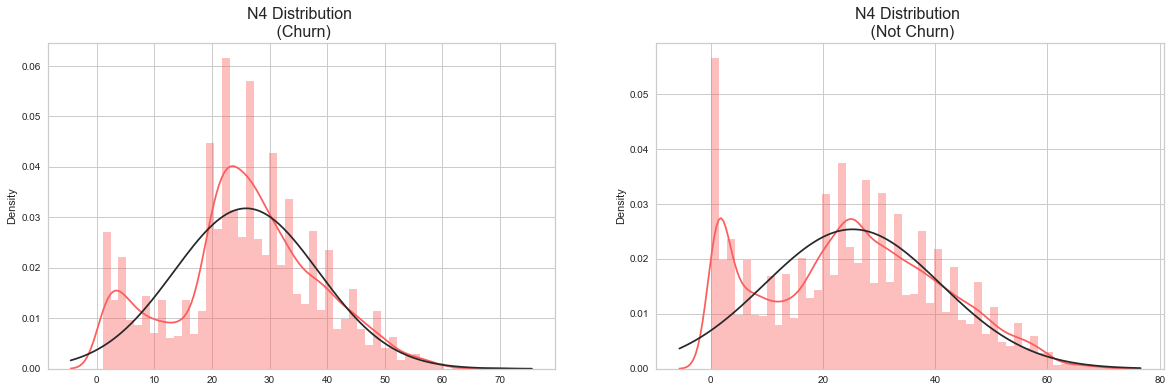

In [12]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

N4_churn = df['N4'].loc[df['Churn'] == 1].values
sns.distplot(N4_churn,ax=ax1, fit=norm, color='#fc5d5d')
ax1.set_title('N4 Distribution \n (Churn)', fontsize=16)

N4_not_churn = df['N4'].loc[df['Churn'] == 0].values
sns.distplot(N4_not_churn,ax=ax2, fit=norm, color='#fc5d5d')
ax2.set_title('N4 Distribution \n (Not Churn)', fontsize=16)

plt.show()

**Distributions (N4):** Both distributions for N4 (Churn and Not Churn) show ~ bernoulli distribution characteristic

## 2.2 EDA on Categorical data

In [13]:
plt.style.use('default')
df2 = df.copy()
for feature in cat_col:
    df2[feature] = df2[feature].astype(str)
    if feature != 'Churn':
        df2_g = df2[[feature, 'Churn']].groupby([feature, 'Churn']).size().reset_index()
        df2_g['percentage'] = df2[[feature, 'Churn']].groupby([feature, 'Churn']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
        df2_g.columns = [feature, 'Churn', 'Counts', 'Percentage']
        
        
        #df2_g[f'{feature}_SORT'] = df2_g[feature].apply(lambda x: int(x.split('-')[-1]))
        #df2_g = df2_g.sort_values(by=[f'{feature}_SORT'], ascending=True).reset_index(drop=True)

        # If the Churn column contain 'Y' value in the first row of the dataframe, add a 'N' value to the first row
        if df2_g.iloc[0:1, :]['Churn'].tolist()[0] == 'Y':
            df2_g.loc[-1] = [df2_g.iloc[0:1, :][feature].tolist()[0], 0, 'N', 0, df2_g.iloc[0:1, :][f'{feature}_SORT'].tolist()[0]]  # adding a row
            df2_g.index = df2_g.index + 1  # shifting index
            df2_g.sort_index(inplace=True)
        #df2_g.drop(labels=[f'{feature}_SORT'], axis=1, inplace=True)
        # df2_g.to_excel(excel_writer=f'df2_g_{feature}.xlsx', index=False)

        fig = px.bar(df2_g, x=feature, y=['Counts'], barmode="group", color='Churn', text=df2_g['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))
        fig.update_layout(title_text=f'{feature} vs Churn', title_x = 0.5, font_size=12)
        fig.show()

# 3. Data Preprocessing

In [14]:
#Dataframe
def pprint_df(dframe):
    print(tabulate(dframe, headers='keys', tablefmt='psql', showindex=False))

## 3.1 Drop duplicates
Our main aim in this section is to resolve duplicate rows from the dataset.  <br><br>

### Duplicates:
<ul>
<li> <b>Higher weight: </b> Duplicates existing in our data are useless and keeping them in the dataset will give them a higher weight to the particular combinations of the feature by these duplicates.  </li>
</ul>

In [15]:
print('Before:',df[df.duplicated()].shape[0])
df = df.sort_values('Churn', ascending=False).drop_duplicates(keep='first').sort_index()
print('After: ',df[df.duplicated()].shape[0])

Before: 8116
After:  0


## 3.2 Cardinality checking

Our main aim in this section is to resolve high cardinality from categorical features.  <br><br>

### High cardinality:
<ul>
<li> <b>The Curse of Dimensionality: </b> When the number of features grows, the amount of data we need to accurately be able to distinguish between these features (in order to give us a prediction) and generalize our model (learned function) grows EXPONENTIALLY.  </li>
<li> <b>High space consumption: </b> More memory will be used to store the information especially if we one-hot encoding for these categorical data. </li>
</ul>

In [16]:
def cardinality_chk(df):
    arr1 = []
    arr2 = []
    for x in df.columns:
        if x.startswith('C'):
            if x != 'Churn':
                arr1.append(x)
                arr2.append(len(df[x].value_counts()))

    pprint_df(pd.DataFrame(list(zip(arr1, arr2)),columns =['Feature','Cardinality']).sort_values(by='Cardinality', ascending=False))

In [17]:
cardinality_chk(df)

+-----------+---------------+
| Feature   |   Cardinality |
|-----------+---------------|
| C2        |             6 |
| C5        |             6 |
| C4        |             5 |
| C9        |             5 |
| C3        |             4 |
| C7        |             4 |
| C10       |             4 |
| C11       |             4 |
| C12       |             4 |
| C1        |             2 |
| C6        |             2 |
| C8        |             2 |
| C13       |             2 |
+-----------+---------------+


**Note:** The unique values in categorical data are within a acceptance range (<10)

## 3.3 Check for correlation 


Our main aim in this section is to remove highly correlated features.  <br><br>


### Occam's razor:
<ul>
<li> <b>Note 1: </b> Occam’s razor is a heuristic that suggests choosing simpler machine learning models as they are expected to generalize better. </li>
<li> <b>Note 2: </b> The heuristic can be divided into two razors, one of which is true and remains a useful tool and the other that is false and should be abandoned. </li>
<li> <b>Note 3: </b> Ensemble learning algorithms like boosting provide a specific case of how the second razor fails and added complexity can result in lower generalization error. </li>
</ul>

In [18]:
corr = df[num_col].corr()
corr.style.background_gradient(cmap='coolwarm')

**Note:** There is no highly correlated features (>0.8)

## 3.4 Missing values

In [19]:
df.isnull().sum()

C1       0
C2       0
C3       0
C4       0
C5       0
C6       0
N1       0
C7       0
N2       0
C8       0
C9       0
C10      0
C11      0
C12      0
C13      0
N3       0
N4       0
Churn    0
dtype: int64

**Note:** There is missing values

## 3.5 Outliers Detection:


Our main aim in this section is to remove "outliers" from numerical features.  <br><br>


### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance passes this threshold the instance will be deleted.  </li>
<li> <b>Boxplots: </b> Besides easily seeing the 25th and 75th percentiles (both ends of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). </li>
</ul>

### Outlier Removal Tradeoff:
We have to be careful as to how far we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.  <br><br>

**The Tradeoff: **
The lower the threshold the more outliers it will remove however. We can play with this threshold and see how it affects the accuracy of our classification models.


### Summary:
<ul>
<li> <b> Visualize Distributions: </b> We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. </li>
<li><b>Determining the threshold: </b> Upper and lower whisker will be our threshold in order to remove these outliers. </li>
<li> <b>Conditional Replacement: </b> Lastly, we create a conditional replacement if the instances exceed upper and lower whiskers. </li>
<li> <b> Box Plot Representation: </b> Visualize through the boxplot that the number of outliers have been reduced to a considerable amount. </li>
</ul>


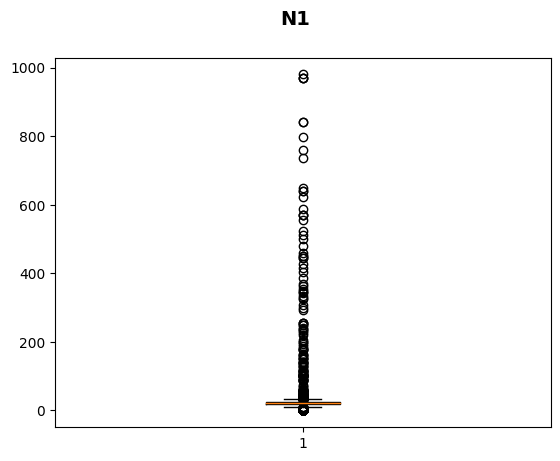

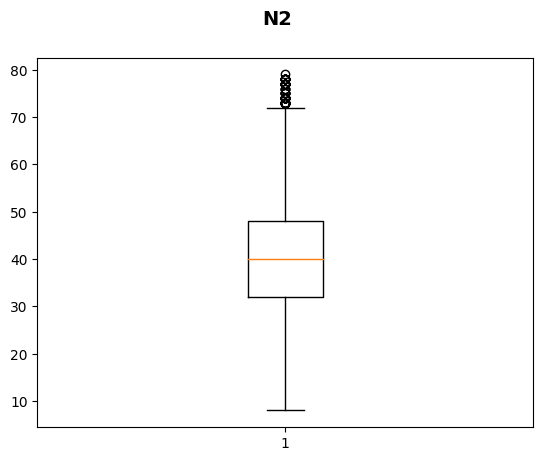

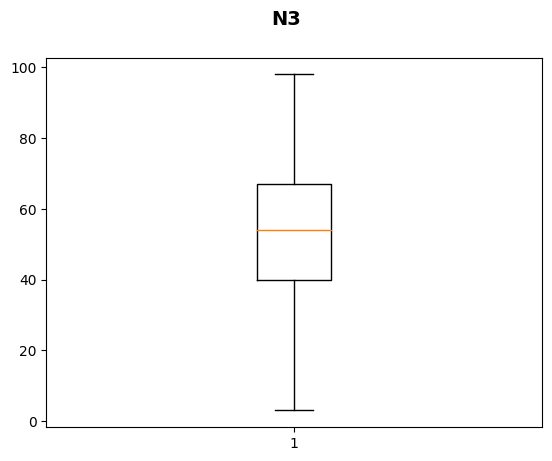

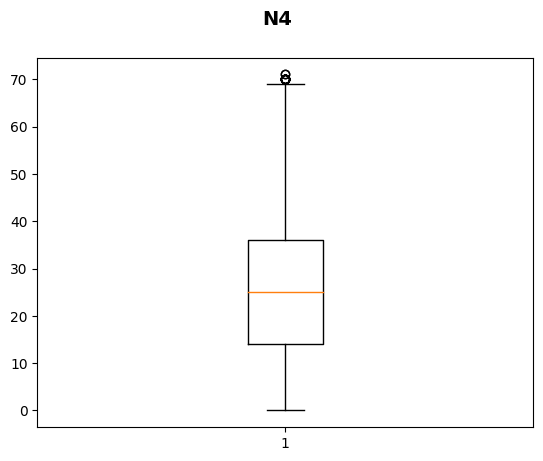

In [20]:
#Outliers detection
#Show data in boxplots
Numeric_dic = {}
for x in num_col:
    Numeric_dic[x]= df[x].to_numpy()
    
for x in Numeric_dic:
    fig = plt.figure()
    fig.suptitle(x, fontsize=14, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.boxplot(Numeric_dic[x])
    plt.show()

<h3> Note: I have the underlying information of these features:</h3>
<ul> 
<li> N1, N2 and N4 do have outliers. </li>
<li> Outliers in <b>N1</b> belong to <b>Data Entry Errors.</b> </li>
<li> Outliers in <b>N2</b> and <b>N4</b> belong to <b>Natural Outlier</b>. </li>
</ul>


In [21]:
# -----> N1 removing outliers from churn customers
N1_churn = df['N1'].loc[df['Churn'] == 1].values
q25, q75 = np.percentile(N1_churn, 25), np.percentile(N1_churn, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
N1_iqr = q75 - q25
print('iqr: {}'.format(N1_iqr))

N1_cut_off = N1_iqr * 1.5
N1_lower, N1_upper = q25 - N1_cut_off, q75 + N1_cut_off
print('Cut Off: {}'.format(N1_cut_off))
print('N1 Lower: {}'.format(N1_lower))
print('N1 Upper: {}'.format(N1_upper))

outliers = [x for x in N1_churn if x < N1_lower or x > N1_upper]
print('Feature N1 Outliers for churn Cases: {}'.format(len(outliers)))
#print('N1 outliers:{}'.format(outliers))

df = df.drop(df[(df['N1'] > N1_upper) | (df['N1'] < N1_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))
print('----' * 30)

# -----> N2 removing outliers from churn customers
N2_churn = df['N2'].loc[df['Churn'] == 1].values
q25, q75 = np.percentile(N2_churn, 25), np.percentile(N2_churn, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
N2_iqr = q75 - q25

N2_cut_off = N2_iqr * 1.5
N2_lower, N2_upper = q25 - N2_cut_off, q75 + N2_cut_off
print('N2 Lower: {}'.format(N2_lower))
print('N2 Upper: {}'.format(N2_upper))
outliers = [x for x in N2_churn if x < N2_lower or x > N2_upper]
#print('N2 outliers: {}'.format(outliers))
print('Feature N2 Outliers for churn Cases: {}'.format(len(outliers)))
df = df.drop(df[(df['N2'] > N2_upper) | (df['N2'] < N2_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))
print('----' * 30)


# -----> N3 removing outliers from churn customers
N3_churn = df['N3'].loc[df['Churn'] == 1].values
q25, q75 = np.percentile(N3_churn, 25), np.percentile(N3_churn, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
N3_iqr = q75 - q25

N3_cut_off = N3_iqr * 1.5
N3_lower, N3_upper = q25 - N3_cut_off, q75 + N3_cut_off
print('N3 Lower: {}'.format(N3_lower))
print('N3 Upper: {}'.format(N3_upper))
outliers = [x for x in N3_churn if x < N3_lower or x > N3_upper]
#print('N3 outliers: {}'.format(outliers))
print('Feature N3 Outliers for churn Cases: {}'.format(len(outliers)))
df = df.drop(df[(df['N3'] > N3_upper) | (df['N3'] < N3_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))
print('----' * 30)


# -----> N4 removing outliers from churn customers
N4_churn = df['N4'].loc[df['Churn'] == 1].values
q25, q75 = np.percentile(N4_churn, 25), np.percentile(N4_churn, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
N4_iqr = q75 - q25

N4_cut_off = N4_iqr * 1.5
N4_lower, N4_upper = q25 - N4_cut_off, q75 + N4_cut_off
print('N4 Lower: {}'.format(N4_lower))
print('N4 Upper: {}'.format(N4_upper))
outliers = [x for x in N4_churn if x < N4_lower or x > N4_upper]
#print('N4 outliers: {}'.format(outliers))
print('Feature N4 Outliers for churn Cases: {}'.format(len(outliers)))
df = df.drop(df[(df['N4'] > N4_upper) | (df['N4'] < N4_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))

Quartile 25: 19.0 | Quartile 75: 24.4
iqr: 5.399999999999999
Cut Off: 8.099999999999998
N1 Lower: 10.900000000000002
N1 Upper: 32.5
Feature N1 Outliers for churn Cases: 417
Number of Instances after outliers removal: 46792
------------------------------------------------------------------------------------------------------------------------
Quartile 25: 28.0 | Quartile 75: 48.0
N2 Lower: -2.0
N2 Upper: 78.0
Feature N2 Outliers for churn Cases: 0
Number of Instances after outliers removal: 46791
------------------------------------------------------------------------------------------------------------------------
Quartile 25: 43.0 | Quartile 75: 64.0
N3 Lower: 11.5
N3 Upper: 95.5
Feature N3 Outliers for churn Cases: 52
Number of Instances after outliers removal: 46634
------------------------------------------------------------------------------------------------------------------------
Quartile 25: 19.0 | Quartile 75: 34.0
N4 Lower: -3.5
N4 Upper: 56.5
Feature N4 Outliers for churn C

**Important:** We remove the outliers for numerical data with equal treat (same technique). And now N1 falls within a acceptance range with no more data entry errors

In [22]:
df[num_col].describe()

N1            N2            N3            N4
count  45725.000000  45725.000000  45725.000000  45725.000000
mean      21.090213     40.467622     54.854806     24.727283
std        3.993857     11.120660     18.111431     14.380970
min       11.000000      8.000000     12.000000      0.000000
25%       18.000000     32.000000     42.000000     14.000000
50%       21.000000     40.000000     55.000000     25.000000
75%       24.000000     48.000000     68.000000     35.000000
max       32.500000     78.000000     95.000000     56.000000

## 3.6 Hypothesis Testing

In [23]:
def chi_square_test(df, feature1, feature2):
    print("========================================================================================")
    print(feature1 + ' & ' + feature2)
    # create contingency table
    data_crosstab = pd.crosstab(df[feature1],
                                df[feature2],
                               margins=True, margins_name="Total")

    # significance level
    alpha = 0.05

    # Calcualtion of Chisquare
    chi_square = 0
    rows = df[feature1].unique()
    columns = df[feature2].unique()
    for i in columns:
        for j in rows:
            O = data_crosstab[i][j]
            E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
            chi_square += (O-E)**2/E

    # The p-value approach
    print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
    p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    if p_value <= alpha:
        conclusion = "Null Hypothesis is rejected. There is relationship between 2 categorical variables"
    else:
        conclusion = "Failed to reject the null hypothesis. There is no relationship between 2 categorical variables"

    print("chisquare-score is:", chi_square, " and p value is:", p_value)
    print(conclusion)

    # The critical value approach
    print("\n--------------------------------------------------------------------------------------")
    print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
    critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))

    if chi_square > critical_value:
        conclusion = "Null Hypothesis is rejected. There is relationship between 2 categorical variables"
    else:
        conclusion = "Failed to reject the null hypothesis. There is no relationship between 2 categorical variables"

    print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
    print(conclusion)
    print()
    

In [24]:
for i in cat_col:
    chi_square_test(df,i,'Churn')

C1 & Churn
Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 401.57869678316035  and p value is: 0.0
Null Hypothesis is rejected. There is relationship between 2 categorical variables

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 401.57869678316035  and critical value is: 3.841458820694124
Null Hypothesis is rejected. There is relationship between 2 categorical variables

C2 & Churn
Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 1245.857422440223  and p value is: 0.0
Null Hypothesis is rejected. There is relationship between 2 categorical variables

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 1245.857422440

**Note:**  Don't rely for your interpretation on p-values when your samples are very large.
The p-value is just the probability of getting this or more extreme data if the null hypothesis is true, with huge data this probability can get arbitrarily small.

# 4. Machine Learning Modeling

<h3> Note: </h3>
<ul> 
<li> Due to imbalanced dataset and majority of the features are categorical data.</li>
<li> Ensemble models / Tree-based models will be a better approach. </li>
<li> The selected models are <b>LightGBM</b> and <b>XGBoost</b>.  </li>
</ul>

In [25]:
df['Churn'] = df['Churn'].apply(lambda x:1 if x ==True else 0)

In [26]:
#Independent variables
X = df.drop(columns = ['Churn'])

# for i in X.columns:
#     if i.startswith('C'):
#         X[i] = X[i].astype('category')

#Dependent variable
y = df['Churn']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state = 44)
y_train = pd.DataFrame(data=y_train)
y_test = pd.DataFrame(data=y_test)

In [28]:
# Tree-based data
display(Markdown(f"### Tree-based data"))
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

print("Shape of X_train dataset: ", X_train.shape)
print("Shape of y_train dataset: ", y_train.shape)
print("Shape of X_test dataset: ", X_test.shape)
print("Shape of y_test dataset: ", y_test.shape)

### Tree-based data

Shape of X: (45725, 17)
Shape of y: (45725,)
Shape of X_train dataset:  (36580, 17)
Shape of y_train dataset:  (36580, 1)
Shape of X_test dataset:  (9145, 17)
Shape of y_test dataset:  (9145, 1)


In [29]:
scale_pos_weight=(y_train.value_counts()[0])/(y_train.value_counts()[1])

## 4.1 LightGBM

### First try with baseline lgbm model

In [30]:
lgbm_clf = LGBMClassifier(metric='average_precision', scale_pos_weight = scale_pos_weight)

lgbm_clf.fit(X_train, y_train)

LGBMClassifier(metric='average_precision', scale_pos_weight=4.019898449293262)

In [31]:
y_train_pred = lgbm_clf.predict(X_train)
y_test_pred = lgbm_clf.predict(X_test)

print("Accuracy Train: {:.4f}\nAccuracy Test: {:.4f}".format(accuracy_score(y_train, y_train_pred),
                                                    accuracy_score(y_test, y_test_pred)))
print()
print("Precision Train: {:.4f}\nPrecision Test: {:.4f}".format(precision_score(y_train, y_train_pred),
                                                    precision_score(y_test, y_test_pred)))
print()
print("Recall Train: {:.4f}\nRecall Test: {:.4f}".format(recall_score(y_train, y_train_pred),
                                                    recall_score(y_test, y_test_pred)))
print()
print("F1 Train: {:.4f}\nF1 Test: {:.4f}".format(f1_score(y_train, y_train_pred),
                                                        f1_score(y_test, y_test_pred)))
print()
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, lgbm_clf.predict_proba(X_train)[:,1]),
                                                    roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])))

Accuracy Train: 0.8597
Accuracy Test: 0.8455

Precision Train: 0.6024
Precision Test: 0.5797

Recall Train: 0.8694
Recall Test: 0.8167

F1 Train: 0.7117
F1 Test: 0.6781

AUC Train: 0.9439
AUC Test: 0.9231


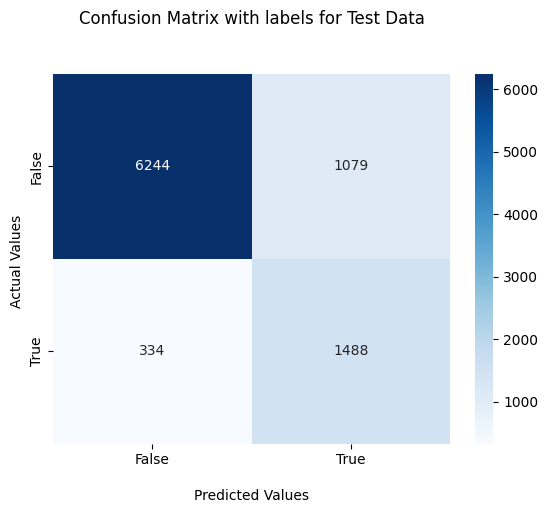

In [32]:
#Generate the confusion matrix for test set
cf_matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix with labels for Test Data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Second try with tuned lgbm model

In [64]:
def objective_lgbm(trial, X, y):
    param_grid = {
        "verbose":-1,
        "scale_pos_weight":scale_pos_weight,
        "n_estimators": trial.suggest_int("n_estimators", 100, 300, step=20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 1600, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 20, step=1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)

    cv_scores = np.empty(5)
    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]

        model = LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_eval, y_eval)],
            eval_metric="average_precision",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "average_precision")
            ],  # Add a pruning callback
        )
        preds = model.predict(X_eval)
        cv_scores[idx] = precision_score(y_eval, preds)

    return np.mean(cv_scores)

In [65]:
#Compile all the data
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

study_lgbm = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func_lgbm = lambda trial: objective_lgbm(trial, X_train, y_train)
study_lgbm.optimize(func_lgbm, n_trials=100)

[I 2022-11-11 10:32:02,013] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=4.647357210563335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.647357210563335
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-11-11 10:32:02,582] Trial 0 finished with value: 0.18095025896789282 and parameters: {'n_estimators': 120, 'learning_rate': 0.15912113455592772, 'num_leaves': 1220, 'max_depth': 10, 'min_data_in_leaf': 1600, 'lambda_l1': 65, 'lambda_l2': 60, 'min_gain_to_split': 4.647357210563335, 'bagging_fraction': 0.5, 'bagging_freq': 17, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.18095025896789282.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=4.647357210563335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.647357210563335
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-11-11 10:32:02,959] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 120, 'learning_rate': 0.2923155581941634, 'num_leaves': 740, 'max_depth': 9, 'min_data_in_leaf': 7900, 'lambda_l1': 100, 'lambda_l2': 75, 'min_gain_to_split': 4.054812161651437, 'bagging_fraction': 0.4, 'bagging_freq': 16, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.18095025896789282.


[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=4.054812161651437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.054812161651437
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGB

[I 2022-11-11 10:32:03,382] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 240, 'learning_rate': 0.017701759413949858, 'num_leaves': 420, 'max_depth': 6, 'min_data_in_leaf': 7500, 'lambda_l1': 75, 'lambda_l2': 25, 'min_gain_to_split': 1.1660685763896184, 'bagging_fraction': 0.7, 'bagging_freq': 5, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.18095025896789282.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7200
[LightGBM] [Warning] min_gain_to_split is set=0.34749506561792876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34749506561792876
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM]

[I 2022-11-11 10:32:03,730] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.14558001168626986, 'num_leaves': 1540, 'max_depth': 5, 'min_data_in_leaf': 7200, 'lambda_l1': 60, 'lambda_l2': 30, 'min_gain_to_split': 0.34749506561792876, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 6, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.18095025896789282.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7200
[LightGBM] [Warning] min_gain_to_split is set=0.34749506561792876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34749506561792876
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM]

[I 2022-11-11 10:32:04,272] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 220, 'learning_rate': 0.17113634982292555, 'num_leaves': 1260, 'max_depth': 9, 'min_data_in_leaf': 3000, 'lambda_l1': 0, 'lambda_l2': 45, 'min_gain_to_split': 7.230666814943946, 'bagging_fraction': 0.7, 'bagging_freq': 14, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.18095025896789282.


[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=7.230666814943946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.230666814943946
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [

[I 2022-11-11 10:32:04,311] Trial 5 pruned. Trial was pruned at iteration 1.
[I 2022-11-11 10:32:04,347] Trial 6 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=1.5837118785903996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5837118785903996
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [

[I 2022-11-11 10:32:04,966] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 180, 'learning_rate': 0.2203692538418051, 'num_leaves': 40, 'max_depth': 11, 'min_data_in_leaf': 3300, 'lambda_l1': 5, 'lambda_l2': 75, 'min_gain_to_split': 11.31749667177704, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 17, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.18095025896789282.
[I 2022-11-11 10:32:05,005] Trial 8 pruned. Trial was pruned at iteration 1.
[I 2022-11-11 10:32:05,041] Trial 9 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=7.706744732270287, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.706744732270287
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warn

[I 2022-11-11 10:32:05,652] Trial 10 finished with value: 0.43083744754767084 and parameters: {'n_estimators': 100, 'learning_rate': 0.09044567093293544, 'num_leaves': 1520, 'max_depth': 12, 'min_data_in_leaf': 300, 'lambda_l1': 80, 'lambda_l2': 10, 'min_gain_to_split': 12.347797487119006, 'bagging_fraction': 0.2, 'bagging_freq': 11, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.43083744754767084.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=12.409987740880549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.409987740880549
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7

[I 2022-11-11 10:32:06,247] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.0846790160537634, 'num_leaves': 1600, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 80, 'lambda_l2': 0, 'min_gain_to_split': 12.409987740880549, 'bagging_fraction': 0.2, 'bagging_freq': 11, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.43083744754767084.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=12.409987740880549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.409987740880549
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3

[I 2022-11-11 10:32:06,881] Trial 12 finished with value: 0.4224166247751221 and parameters: {'n_estimators': 100, 'learning_rate': 0.07290046799447193, 'num_leaves': 1220, 'max_depth': 11, 'min_data_in_leaf': 300, 'lambda_l1': 70, 'lambda_l2': 10, 'min_gain_to_split': 14.595436141649715, 'bagging_fraction': 0.2, 'bagging_freq': 11, 'feature_fraction': 0.7}. Best is trial 10 with value: 0.43083744754767084.
[I 2022-11-11 10:32:06,956] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:07,027] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:07,096] Trial 15 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.772679275823899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.772679275823899
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2022-11-11 10:32:07,168] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:07,333] Trial 17 pruned. Trial was pruned at iteration 106.
[I 2022-11-11 10:32:07,402] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:07,473] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:07,546] Trial 20 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.439882124168536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.439882124168536
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-11-11 10:32:08,307] Trial 21 finished with value: 0.4541829033791583 and parameters: {'n_estimators': 120, 'learning_rate': 0.15935650934615003, 'num_leaves': 1220, 'max_depth': 10, 'min_data_in_leaf': 1000, 'lambda_l1': 65, 'lambda_l2': 55, 'min_gain_to_split': 3.439882124168536, 'bagging_fraction': 0.5, 'bagging_freq': 17, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.4541829033791583.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.319063514291961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.319063514291961
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2022-11-11 10:32:09,043] Trial 22 finished with value: 0.45262991881606585 and parameters: {'n_estimators': 100, 'learning_rate': 0.13798106286817802, 'num_leaves': 1160, 'max_depth': 11, 'min_data_in_leaf': 1000, 'lambda_l1': 70, 'lambda_l2': 65, 'min_gain_to_split': 3.319063514291961, 'bagging_fraction': 0.4, 'bagging_freq': 4, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.4541829033791583.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.319063514291961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.319063514291961
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2022-11-11 10:32:09,861] Trial 23 finished with value: 0.4607948071507983 and parameters: {'n_estimators': 160, 'learning_rate': 0.18352008628646171, 'num_leaves': 1100, 'max_depth': 12, 'min_data_in_leaf': 1200, 'lambda_l1': 80, 'lambda_l2': 65, 'min_gain_to_split': 2.7969868108745235, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'feature_fraction': 0.8}. Best is trial 23 with value: 0.4607948071507983.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=2.7969868108745235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7969868108745235
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[I 2022-11-11 10:32:10,026] Trial 24 pruned. Trial was pruned at iteration 106.
[I 2022-11-11 10:32:10,096] Trial 25 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=2.8124850691054966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8124850691054966
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-11 10:32:10,170] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:10,240] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:10,309] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:10,392] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:10,465] Trial 30 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=7.728050112428843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.728050112428843
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-11-11 10:32:11,145] Trial 31 finished with value: 0.4325194751012583 and parameters: {'n_estimators': 100, 'learning_rate': 0.15443286461640035, 'num_leaves': 1200, 'max_depth': 12, 'min_data_in_leaf': 1600, 'lambda_l1': 80, 'lambda_l2': 50, 'min_gain_to_split': 7.728050112428843, 'bagging_fraction': 0.5, 'bagging_freq': 18, 'feature_fraction': 0.9}. Best is trial 23 with value: 0.4607948071507983.
[I 2022-11-11 10:32:11,238] Trial 32 pruned. Trial was pruned at iteration 25.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=7.680267833522464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.680267833522464
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18


[I 2022-11-11 10:32:11,403] Trial 33 pruned. Trial was pruned at iteration 106.
[I 2022-11-11 10:32:11,475] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:11,547] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:11,619] Trial 36 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.04158580654400801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04158580654400801
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-11-11 10:32:12,603] Trial 37 finished with value: 0.47608579555843633 and parameters: {'n_estimators': 200, 'learning_rate': 0.17694332107767538, 'num_leaves': 1440, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 60, 'lambda_l2': 55, 'min_gain_to_split': 0.04158580654400801, 'bagging_fraction': 0.4, 'bagging_freq': 18, 'feature_fraction': 0.7}. Best is trial 37 with value: 0.47608579555843633.


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.04158580654400801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04158580654400801
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18


[I 2022-11-11 10:32:12,677] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:12,748] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:12,819] Trial 40 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.888922066798719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.888922066798719
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-11 10:32:12,895] Trial 41 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:13,077] Trial 42 pruned. Trial was pruned at iteration 101.
[I 2022-11-11 10:32:13,239] Trial 43 pruned. Trial was pruned at iteration 120.
[I 2022-11-11 10:32:13,457] Trial 44 pruned. Trial was pruned at iteration 120.
[I 2022-11-11 10:32:13,528] Trial 45 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.023952708826037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.023952708826037
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6

[I 2022-11-11 10:32:14,317] Trial 46 finished with value: 0.4768621640206357 and parameters: {'n_estimators': 100, 'learning_rate': 0.11834486283881586, 'num_leaves': 1440, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 85, 'lambda_l2': 30, 'min_gain_to_split': 1.023952708826037, 'bagging_fraction': 0.5, 'bagging_freq': 19, 'feature_fraction': 0.7}. Best is trial 46 with value: 0.4768621640206357.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8219010151161639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8219010151161639
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-11-11 10:32:15,257] Trial 47 finished with value: 0.47871281389607195 and parameters: {'n_estimators': 140, 'learning_rate': 0.12174487001198059, 'num_leaves': 1500, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 85, 'lambda_l2': 30, 'min_gain_to_split': 0.8219010151161639, 'bagging_fraction': 0.5, 'bagging_freq': 19, 'feature_fraction': 0.7}. Best is trial 47 with value: 0.47871281389607195.


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8219010151161639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8219010151161639
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


[I 2022-11-11 10:32:15,503] Trial 48 pruned. Trial was pruned at iteration 166.


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.6853059965257278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6853059965257278
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Wa

[I 2022-11-11 10:32:16,530] Trial 49 finished with value: 0.4949235209105459 and parameters: {'n_estimators': 140, 'learning_rate': 0.11361079491135867, 'num_leaves': 1560, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 95, 'lambda_l2': 25, 'min_gain_to_split': 1.2204914358645769, 'bagging_fraction': 0.8, 'bagging_freq': 17, 'feature_fraction': 0.7}. Best is trial 49 with value: 0.4949235209105459.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2204914358645769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2204914358645769
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is se

[I 2022-11-11 10:32:17,639] Trial 50 finished with value: 0.4933844591607591 and parameters: {'n_estimators': 160, 'learning_rate': 0.12036777919450106, 'num_leaves': 1500, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 95, 'lambda_l2': 25, 'min_gain_to_split': 0.9721386453784274, 'bagging_fraction': 0.9, 'bagging_freq': 19, 'feature_fraction': 0.7}. Best is trial 49 with value: 0.4949235209105459.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9721386453784274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9721386453784274
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is se

[I 2022-11-11 10:32:18,738] Trial 51 finished with value: 0.49903179795458785 and parameters: {'n_estimators': 160, 'learning_rate': 0.11966585832708804, 'num_leaves': 1540, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 95, 'lambda_l2': 25, 'min_gain_to_split': 1.2629523304066803, 'bagging_fraction': 0.9, 'bagging_freq': 19, 'feature_fraction': 0.7}. Best is trial 51 with value: 0.49903179795458785.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.15680567102344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.15680567102344
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500

[I 2022-11-11 10:32:19,874] Trial 52 finished with value: 0.4939740807861007 and parameters: {'n_estimators': 180, 'learning_rate': 0.12167197377868438, 'num_leaves': 1540, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 95, 'lambda_l2': 25, 'min_gain_to_split': 1.15680567102344, 'bagging_fraction': 0.9, 'bagging_freq': 19, 'feature_fraction': 0.7}. Best is trial 51 with value: 0.49903179795458785.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.15680567102344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.15680567102344
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warnin

[I 2022-11-11 10:32:21,189] Trial 53 finished with value: 0.4977039458232143 and parameters: {'n_estimators': 180, 'learning_rate': 0.11779351470905004, 'num_leaves': 1540, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 95, 'lambda_l2': 25, 'min_gain_to_split': 1.1089086138356357, 'bagging_fraction': 0.9, 'bagging_freq': 19, 'feature_fraction': 0.6000000000000001}. Best is trial 51 with value: 0.49903179795458785.
[I 2022-11-11 10:32:21,410] Trial 54 pruned. Trial was pruned at iteration 120.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.4361334217996364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4361334217996364
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


[I 2022-11-11 10:32:21,676] Trial 55 pruned. Trial was pruned at iteration 178.
[I 2022-11-11 10:32:21,888] Trial 56 pruned. Trial was pruned at iteration 106.
[I 2022-11-11 10:32:22,138] Trial 57 pruned. Trial was pruned at iteration 120.
[I 2022-11-11 10:32:22,210] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:22,286] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:22,508] Trial 60 pruned. Trial was pruned at iteration 120.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.032107199740854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.032107199740854
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6

[I 2022-11-11 10:32:23,568] Trial 61 finished with value: 0.49681376697871976 and parameters: {'n_estimators': 140, 'learning_rate': 0.11986211740703467, 'num_leaves': 1460, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 85, 'lambda_l2': 30, 'min_gain_to_split': 1.032107199740854, 'bagging_fraction': 0.9, 'bagging_freq': 19, 'feature_fraction': 0.7}. Best is trial 51 with value: 0.49903179795458785.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.032107199740854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.032107199740854
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=

[I 2022-11-11 10:32:24,653] Trial 62 finished with value: 0.496802343069959 and parameters: {'n_estimators': 140, 'learning_rate': 0.11164219636470765, 'num_leaves': 1400, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 95, 'lambda_l2': 25, 'min_gain_to_split': 0.6170303004698738, 'bagging_fraction': 0.9, 'bagging_freq': 20, 'feature_fraction': 0.7}. Best is trial 51 with value: 0.49903179795458785.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6170303004698738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6170303004698738
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


[I 2022-11-11 10:32:24,729] Trial 63 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.33938204661136195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33938204661136195
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


[I 2022-11-11 10:32:25,022] Trial 64 pruned. Trial was pruned at iteration 101.
[I 2022-11-11 10:32:25,098] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:25,175] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:25,268] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:25,350] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:25,626] Trial 69 pruned. Trial was pruned at iteration 178.
[I 2022-11-11 10:32:25,703] Trial 70 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7180719080910112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7180719080910112
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-11-11 10:32:26,777] Trial 71 finished with value: 0.49646714330782055 and parameters: {'n_estimators': 140, 'learning_rate': 0.12611416841158926, 'num_leaves': 1520, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 85, 'lambda_l2': 35, 'min_gain_to_split': 0.7180719080910112, 'bagging_fraction': 0.9, 'bagging_freq': 19, 'feature_fraction': 0.7}. Best is trial 51 with value: 0.49903179795458785.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6155696007758079, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6155696007758079
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-11-11 10:32:27,907] Trial 72 finished with value: 0.49725097102613935 and parameters: {'n_estimators': 160, 'learning_rate': 0.1280280359635742, 'num_leaves': 1540, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 100, 'lambda_l2': 35, 'min_gain_to_split': 0.6155696007758079, 'bagging_fraction': 0.9, 'bagging_freq': 18, 'feature_fraction': 0.7}. Best is trial 51 with value: 0.49903179795458785.
[I 2022-11-11 10:32:27,987] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:28,063] Trial 74 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=1.864159736336905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.864159736336905
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17


[I 2022-11-11 10:32:28,291] Trial 75 pruned. Trial was pruned at iteration 101.
[I 2022-11-11 10:32:28,367] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:28,461] Trial 77 pruned. Trial was pruned at iteration 10.
[I 2022-11-11 10:32:28,669] Trial 78 pruned. Trial was pruned at iteration 101.
[I 2022-11-11 10:32:28,744] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:28,938] Trial 80 pruned. Trial was pruned at iteration 101.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9721966429026434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9721966429026434
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-11-11 10:32:30,303] Trial 81 finished with value: 0.4945563230156562 and parameters: {'n_estimators': 160, 'learning_rate': 0.11684654773509796, 'num_leaves': 1460, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 95, 'lambda_l2': 25, 'min_gain_to_split': 0.9721966429026434, 'bagging_fraction': 0.9, 'bagging_freq': 19, 'feature_fraction': 0.7}. Best is trial 51 with value: 0.49903179795458785.
[I 2022-11-11 10:32:30,383] Trial 82 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=1.1078015213093884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1078015213093884
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19


[I 2022-11-11 10:32:30,637] Trial 83 pruned. Trial was pruned at iteration 101.
[I 2022-11-11 10:32:30,830] Trial 84 pruned. Trial was pruned at iteration 100.
[I 2022-11-11 10:32:30,909] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:32:31,000] Trial 86 pruned. Trial was pruned at iteration 3.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3351006767233086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3351006767233086
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-11-11 10:32:32,461] Trial 87 finished with value: 0.5031229835436536 and parameters: {'n_estimators': 140, 'learning_rate': 0.09000042240132775, 'num_leaves': 1340, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 90, 'lambda_l2': 25, 'min_gain_to_split': 0.3351006767233086, 'bagging_fraction': 0.9, 'bagging_freq': 10, 'feature_fraction': 0.8}. Best is trial 87 with value: 0.5031229835436536.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.06635627115683274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06635627115683274
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-11-11 10:32:34,027] Trial 88 finished with value: 0.5033067430118516 and parameters: {'n_estimators': 140, 'learning_rate': 0.08931192278878958, 'num_leaves': 1340, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 90, 'lambda_l2': 45, 'min_gain_to_split': 0.06635627115683274, 'bagging_fraction': 0.9, 'bagging_freq': 10, 'feature_fraction': 0.8}. Best is trial 88 with value: 0.5033067430118516.
[I 2022-11-11 10:32:34,109] Trial 89 pruned. Trial was pruned at iteration 2.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.35000482483503564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35000482483503564
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-11-11 10:32:35,589] Trial 90 finished with value: 0.5080262869459101 and parameters: {'n_estimators': 120, 'learning_rate': 0.08674053193745504, 'num_leaves': 140, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 75, 'lambda_l2': 40, 'min_gain_to_split': 0.11388051478321481, 'bagging_fraction': 0.9, 'bagging_freq': 9, 'feature_fraction': 0.8}. Best is trial 90 with value: 0.5080262869459101.
[I 2022-11-11 10:32:35,678] Trial 91 pruned. Trial was pruned at iteration 5.
[I 2022-11-11 10:32:35,767] Trial 92 pruned. Trial was pruned at iteration 4.
[I 2022-11-11 10:32:35,850] Trial 93 pruned. Trial was pruned at iteration 2.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.0019329702472266064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0019329702472266064
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-11-11 10:32:36,936] Trial 94 finished with value: 0.4976554805574841 and parameters: {'n_estimators': 120, 'learning_rate': 0.10284173340069991, 'num_leaves': 760, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 90, 'lambda_l2': 30, 'min_gain_to_split': 0.8099500937923032, 'bagging_fraction': 0.9, 'bagging_freq': 10, 'feature_fraction': 0.8}. Best is trial 90 with value: 0.5080262869459101.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8099500937923032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8099500937923032
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2022-11-11 10:32:37,018] Trial 95 pruned. Trial was pruned at iteration 2.
[I 2022-11-11 10:32:37,116] Trial 96 pruned. Trial was pruned at iteration 18.
[I 2022-11-11 10:32:37,195] Trial 97 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.8321040330407663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8321040330407663
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-11-11 10:32:38,456] Trial 98 finished with value: 0.520524067964911 and parameters: {'n_estimators': 120, 'learning_rate': 0.10784584843359912, 'num_leaves': 740, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 40, 'lambda_l2': 50, 'min_gain_to_split': 0.004971189299221468, 'bagging_fraction': 0.9, 'bagging_freq': 7, 'feature_fraction': 0.9}. Best is trial 98 with value: 0.520524067964911.
[I 2022-11-11 10:32:38,535] Trial 99 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.20714911246587603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20714911246587603
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [69]:
print(f"Best value: {study_lgbm.best_value:.5f}")
print(f"Best params:")

lgbm_parameters = {}
for key, value in study_lgbm.best_params.items():
    #print(f"\t\t{key}: {value}")
    lgbm_parameters[key] = value

lgbm_parameters

Best value: 0.52052
Best params:


{'n_estimators': 240,
 'learning_rate': 0.27064577655072514,
 'num_leaves': 960,
 'max_depth': 10,
 'min_data_in_leaf': 200,
 'lambda_l1': 0,
 'lambda_l2': 30,
 'min_gain_to_split': 0.7020459002841588,
 'bagging_fraction': 0.5,
 'bagging_freq': 2,
 'feature_fraction': 0.6000000000000001}

In [70]:
lgbm_clf_tuned = LGBMClassifier(objective="binary", **lgbm_parameters)

lgbm_clf_tuned.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7020459002841588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7020459002841588
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


LGBMClassifier(bagging_fraction=0.5, bagging_freq=2,
               feature_fraction=0.6000000000000001, lambda_l1=0, lambda_l2=30,
               learning_rate=0.27064577655072514, max_depth=10,
               min_data_in_leaf=200, min_gain_to_split=0.7020459002841588,
               n_estimators=240, num_leaves=960, objective='binary')

In [71]:
y_train_pred = lgbm_clf_tuned.predict(X_train)
y_test_pred = lgbm_clf_tuned.predict(X_test)

print("Accuracy Train: {:.4f}\nAccuracy Test: {:.4f}".format(accuracy_score(y_train, y_train_pred),
                                                    accuracy_score(y_test, y_test_pred)))
print()
print("Precision Train: {:.4f}\nPrecision Test: {:.4f}".format(precision_score(y_train, y_train_pred),
                                                    precision_score(y_test, y_test_pred)))
print()
print("Recall Train: {:.4f}\nRecall Test: {:.4f}".format(recall_score(y_train, y_train_pred),
                                                    recall_score(y_test, y_test_pred)))
print()
print("F1 Train: {:.4f}\nF1 Test: {:.4f}".format(f1_score(y_train, y_train_pred),
                                                        f1_score(y_test, y_test_pred)))
print()
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, lgbm_clf_tuned.predict_proba(X_train)[:,1]),
                                                    roc_auc_score(y_test, lgbm_clf_tuned.predict_proba(X_test)[:,1])))

Accuracy Train: 0.9125
Accuracy Test: 0.8991

Precision Train: 0.8722
Precision Test: 0.8312

Recall Train: 0.6568
Recall Test: 0.6191

F1 Train: 0.7493
F1 Test: 0.7097

AUC Train: 0.9389
AUC Test: 0.9187


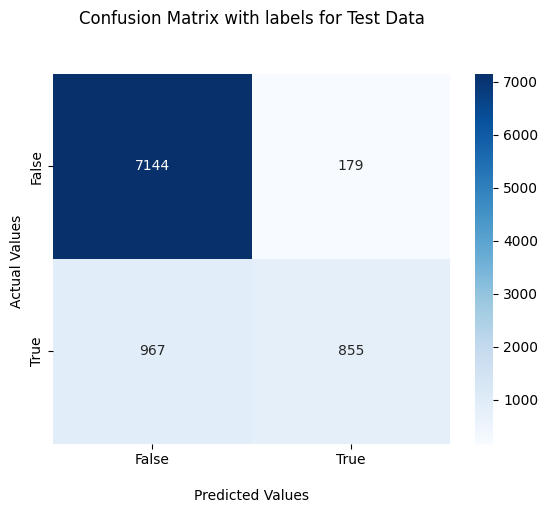

In [38]:
#Generate the confusion matrix for test set
cf_matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix with labels for Test Data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### LGBM
### Tuned > baseline  (Precision)
<h3> Summary: </h3>
<ul> 
<li>One of the potentials problem is when the precision-recall tradeoff is unequal (heavily biased) and the selected model has no suitable metric to control them, it will usually neglect one of metrics as shown above. </li>
<li>It will sacrifice recall in order to achieve a good precision and vice-versa. </li>
<li>Tuned LGBM: (83% prec vs 61% recall)</li>
</ul>

## 4.2 XGBoost

### First try on baseline xgb model

In [39]:
#Independent variables
X = df.drop(columns = ['Churn'])

#Dependent variable
y = df['Churn']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state = 44)
y_train = pd.DataFrame(data=y_train)
y_test = pd.DataFrame(data=y_test)

In [41]:
xgb_clf = XGBClassifier(scale_pos_weight = scale_pos_weight)

xgb_clf.fit(X_train, y_train)

[10:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.019898449293262,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print("Accuracy Train: {:.4f}\nAccuracy Test: {:.4f}".format(accuracy_score(y_train, y_train_pred),
                                                    accuracy_score(y_test, y_test_pred)))
print()
print("Precision Train: {:.4f}\nPrecision Test: {:.4f}".format(precision_score(y_train, y_train_pred),
                                                    precision_score(y_test, y_test_pred)))
print()
print("Recall Train: {:.4f}\nRecall Test: {:.4f}".format(recall_score(y_train, y_train_pred),
                                                    recall_score(y_test, y_test_pred)))
print()
print("F1 Train: {:.4f}\nF1 Test: {:.4f}".format(f1_score(y_train, y_train_pred),
                                                        f1_score(y_test, y_test_pred)))
print()
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:,1]),
                                                    roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])))

Accuracy Train: 0.9035
Accuracy Test: 0.8656

Precision Train: 0.6980
Precision Test: 0.6272

Recall Train: 0.9092
Recall Test: 0.8024

F1 Train: 0.7897
F1 Test: 0.7041

AUC Train: 0.9694
AUC Test: 0.9233


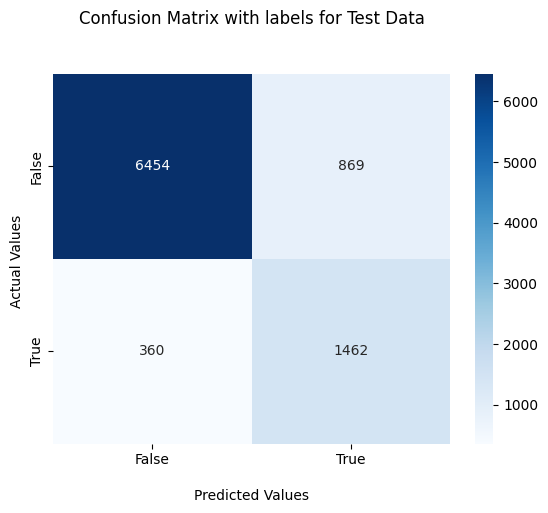

In [43]:
#Generate the confusion matrix for test set
cf_matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix with labels for Test Data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Second try on tuned xgb model

In [44]:
def objective_xgb(trial, X, y):
    param_grid = {
            "verbosity":0,
            "silent":True,
            "objective": "binary:logistic",
            "eval_metric": "aucpr",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear","dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.2, 0.80, step=0.1),
            "scale_pos_weight": scale_pos_weight,
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.80, step=0.1),
            'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.5, 0.95, step=0.1),
            'min_child_weight': trial.suggest_int("min_child_weight", 1, 10, step=1)
        }

    if param_grid["booster"] == "gbtree" or param_grid["booster"] == "dart":
        param_grid["n_estimators"] = trial.suggest_int("n_estimators", 10, 200, step=20)
        param_grid["max_depth"] = trial.suggest_int("max_depth", 3, 12)
        param_grid["max_leaves"] = trial.suggest_int("max_leaves", 20, 500, step=20)
        param_grid["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param_grid["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param_grid["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
            
    if param_grid["booster"] == "dart":
        param_grid["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param_grid["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param_grid["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param_grid["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]

        model = XGBClassifier(**param_grid)
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_eval, y_eval)],
            early_stopping_rounds=100,
            callbacks=[
                XGBoostPruningCallback(trial, "validation_0-aucpr")
            ],  # Add a pruning callback
        )
  
        preds = model.predict(X_eval)
        cv_scores[idx] = precision_score(y_eval, preds)

    return np.mean(cv_scores)

In [45]:
#Compile all the data
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

study_xgb = optuna.create_study(direction="maximize", study_name="XGB Classifier")
func_xgb = lambda trial: objective_xgb(trial, X_train, y_train)
study_xgb.optimize(func_xgb, n_trials=20) #Xgb is will consume more time compare to lgbm

[I 2022-11-11 10:23:08,234] A new study created in memory with name: XGB Classifier


[0]	validation_0-aucpr:0.45219
[1]	validation_0-aucpr:0.61284
[2]	validation_0-aucpr:0.63097
[3]	validation_0-aucpr:0.64560
[4]	validation_0-aucpr:0.66647
[5]	validation_0-aucpr:0.68083
[6]	validation_0-aucpr:0.68147
[7]	validation_0-aucpr:0.67896
[8]	validation_0-aucpr:0.68194
[9]	validation_0-aucpr:0.68961
[10]	validation_0-aucpr:0.69516
[11]	validation_0-aucpr:0.70145
[12]	validation_0-aucpr:0.70289
[13]	validation_0-aucpr:0.70294
[14]	validation_0-aucpr:0.70586
[15]	validation_0-aucpr:0.71848
[16]	validation_0-aucpr:0.72011
[17]	validation_0-aucpr:0.71860
[18]	validation_0-aucpr:0.72050
[19]	validation_0-aucpr:0.72560
[20]	validation_0-aucpr:0.73445
[21]	validation_0-aucpr:0.73561
[22]	validation_0-aucpr:0.73706
[23]	validation_0-aucpr:0.74273
[24]	validation_0-aucpr:0.74497
[25]	validation_0-aucpr:0.74603
[26]	validation_0-aucpr:0.74709
[27]	validation_0-aucpr:0.74833
[28]	validation_0-aucpr:0.75292
[29]	validation_0-aucpr:0.75282
[0]	validation_0-aucpr:0.42013
[1]	validation_0-au

[I 2022-11-11 10:23:10,492] Trial 0 finished with value: 0.4807690588915884 and parameters: {'booster': 'dart', 'lambda': 0.0007663949900045084, 'alpha': 0.03953042432267594, 'learning_rate': 0.13941130378497146, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 4, 'n_estimators': 30, 'max_depth': 4, 'max_leaves': 380, 'eta': 0.001039201575399617, 'gamma': 6.293834310547695e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0481006856617303e-05, 'skip_drop': 6.916601644511934e-06}. Best is trial 0 with value: 0.4807690588915884.


[0]	validation_0-aucpr:0.56924
[1]	validation_0-aucpr:0.59645
[2]	validation_0-aucpr:0.64193
[3]	validation_0-aucpr:0.67747
[4]	validation_0-aucpr:0.68878
[5]	validation_0-aucpr:0.69027
[6]	validation_0-aucpr:0.70071
[7]	validation_0-aucpr:0.71228
[8]	validation_0-aucpr:0.71208
[9]	validation_0-aucpr:0.71922
[10]	validation_0-aucpr:0.73162
[11]	validation_0-aucpr:0.73301
[12]	validation_0-aucpr:0.73913
[13]	validation_0-aucpr:0.73892
[14]	validation_0-aucpr:0.74134
[15]	validation_0-aucpr:0.74316
[16]	validation_0-aucpr:0.74328
[17]	validation_0-aucpr:0.74673
[18]	validation_0-aucpr:0.74827
[19]	validation_0-aucpr:0.74887
[20]	validation_0-aucpr:0.75079
[21]	validation_0-aucpr:0.75303
[22]	validation_0-aucpr:0.75930
[23]	validation_0-aucpr:0.76299
[24]	validation_0-aucpr:0.76403
[25]	validation_0-aucpr:0.76628
[26]	validation_0-aucpr:0.76912
[27]	validation_0-aucpr:0.76925
[28]	validation_0-aucpr:0.76955
[29]	validation_0-aucpr:0.76889
[30]	validation_0-aucpr:0.76989
[31]	validation_0-

[71]	validation_0-aucpr:0.80010
[72]	validation_0-aucpr:0.80031
[73]	validation_0-aucpr:0.79960
[74]	validation_0-aucpr:0.79976
[75]	validation_0-aucpr:0.79951
[76]	validation_0-aucpr:0.79765
[77]	validation_0-aucpr:0.79737
[78]	validation_0-aucpr:0.79843
[79]	validation_0-aucpr:0.79814
[80]	validation_0-aucpr:0.79937
[81]	validation_0-aucpr:0.80054
[82]	validation_0-aucpr:0.80092
[83]	validation_0-aucpr:0.80125
[84]	validation_0-aucpr:0.80127
[85]	validation_0-aucpr:0.80129
[86]	validation_0-aucpr:0.80074
[87]	validation_0-aucpr:0.80122
[88]	validation_0-aucpr:0.80188
[89]	validation_0-aucpr:0.80181
[90]	validation_0-aucpr:0.80244
[91]	validation_0-aucpr:0.80226
[92]	validation_0-aucpr:0.80224
[93]	validation_0-aucpr:0.80209
[94]	validation_0-aucpr:0.80129
[95]	validation_0-aucpr:0.80094
[96]	validation_0-aucpr:0.80119
[97]	validation_0-aucpr:0.80181
[98]	validation_0-aucpr:0.80170
[99]	validation_0-aucpr:0.80190
[100]	validation_0-aucpr:0.80154
[101]	validation_0-aucpr:0.80152
[102]	

[134]	validation_0-aucpr:0.76565
[135]	validation_0-aucpr:0.76676
[136]	validation_0-aucpr:0.76702
[137]	validation_0-aucpr:0.76796
[138]	validation_0-aucpr:0.76719
[139]	validation_0-aucpr:0.76696
[140]	validation_0-aucpr:0.76768
[141]	validation_0-aucpr:0.76832
[142]	validation_0-aucpr:0.76816
[143]	validation_0-aucpr:0.76803
[144]	validation_0-aucpr:0.76848
[145]	validation_0-aucpr:0.76792
[146]	validation_0-aucpr:0.76777
[147]	validation_0-aucpr:0.76828
[148]	validation_0-aucpr:0.76785
[149]	validation_0-aucpr:0.76827
[150]	validation_0-aucpr:0.76788
[151]	validation_0-aucpr:0.76706
[152]	validation_0-aucpr:0.76734
[153]	validation_0-aucpr:0.76825
[154]	validation_0-aucpr:0.76851
[155]	validation_0-aucpr:0.76858
[156]	validation_0-aucpr:0.76843
[157]	validation_0-aucpr:0.76870
[158]	validation_0-aucpr:0.76854
[159]	validation_0-aucpr:0.76799
[160]	validation_0-aucpr:0.76692
[161]	validation_0-aucpr:0.76748
[162]	validation_0-aucpr:0.76737
[163]	validation_0-aucpr:0.76786
[164]	vali

[6]	validation_0-aucpr:0.72281
[7]	validation_0-aucpr:0.72774
[8]	validation_0-aucpr:0.73205
[9]	validation_0-aucpr:0.74444
[10]	validation_0-aucpr:0.75279
[11]	validation_0-aucpr:0.75623
[12]	validation_0-aucpr:0.75874
[13]	validation_0-aucpr:0.75972
[14]	validation_0-aucpr:0.76171
[15]	validation_0-aucpr:0.76551
[16]	validation_0-aucpr:0.76513
[17]	validation_0-aucpr:0.76481
[18]	validation_0-aucpr:0.76516
[19]	validation_0-aucpr:0.76859
[20]	validation_0-aucpr:0.76954
[21]	validation_0-aucpr:0.77055
[22]	validation_0-aucpr:0.77342
[23]	validation_0-aucpr:0.77373
[24]	validation_0-aucpr:0.77645
[25]	validation_0-aucpr:0.77718
[26]	validation_0-aucpr:0.77944
[27]	validation_0-aucpr:0.77970
[28]	validation_0-aucpr:0.78053
[29]	validation_0-aucpr:0.78154
[30]	validation_0-aucpr:0.78085
[31]	validation_0-aucpr:0.78295
[32]	validation_0-aucpr:0.78404
[33]	validation_0-aucpr:0.78450
[34]	validation_0-aucpr:0.78480
[35]	validation_0-aucpr:0.78577
[36]	validation_0-aucpr:0.78661
[37]	validat

[I 2022-11-11 10:23:16,991] Trial 1 finished with value: 0.5626656284647186 and parameters: {'booster': 'gbtree', 'lambda': 0.0007743913580573414, 'alpha': 6.272857607511223e-05, 'learning_rate': 0.2573332566996438, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'min_child_weight': 10, 'n_estimators': 190, 'max_depth': 5, 'max_leaves': 40, 'eta': 3.464430849216948e-06, 'gamma': 0.9231879022488273, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.5626656284647186.


[0]	validation_0-aucpr:0.67225
[1]	validation_0-aucpr:0.72257
[2]	validation_0-aucpr:0.73842
[3]	validation_0-aucpr:0.76133
[4]	validation_0-aucpr:0.77064
[5]	validation_0-aucpr:0.77255
[6]	validation_0-aucpr:0.77336
[7]	validation_0-aucpr:0.77300
[8]	validation_0-aucpr:0.77209
[9]	validation_0-aucpr:0.77241
[10]	validation_0-aucpr:0.77467
[11]	validation_0-aucpr:0.77474
[12]	validation_0-aucpr:0.77507
[13]	validation_0-aucpr:0.77462
[14]	validation_0-aucpr:0.77680
[15]	validation_0-aucpr:0.77761
[16]	validation_0-aucpr:0.78025
[17]	validation_0-aucpr:0.78044
[18]	validation_0-aucpr:0.78185
[19]	validation_0-aucpr:0.78144
[20]	validation_0-aucpr:0.78213
[21]	validation_0-aucpr:0.78357
[22]	validation_0-aucpr:0.78315
[23]	validation_0-aucpr:0.78454
[24]	validation_0-aucpr:0.78553
[25]	validation_0-aucpr:0.78718
[26]	validation_0-aucpr:0.78807
[27]	validation_0-aucpr:0.78901
[28]	validation_0-aucpr:0.78950
[29]	validation_0-aucpr:0.79017
[30]	validation_0-aucpr:0.79030
[31]	validation_0-

[85]	validation_0-aucpr:0.82376
[86]	validation_0-aucpr:0.82399
[87]	validation_0-aucpr:0.82441
[88]	validation_0-aucpr:0.82471
[89]	validation_0-aucpr:0.82489
[90]	validation_0-aucpr:0.82464
[91]	validation_0-aucpr:0.82474
[92]	validation_0-aucpr:0.82499
[93]	validation_0-aucpr:0.82486
[94]	validation_0-aucpr:0.82507
[95]	validation_0-aucpr:0.82520
[96]	validation_0-aucpr:0.82507
[97]	validation_0-aucpr:0.82538
[98]	validation_0-aucpr:0.82567
[99]	validation_0-aucpr:0.82538
[100]	validation_0-aucpr:0.82569
[101]	validation_0-aucpr:0.82618
[102]	validation_0-aucpr:0.82682
[103]	validation_0-aucpr:0.82710
[104]	validation_0-aucpr:0.82730
[105]	validation_0-aucpr:0.82726
[106]	validation_0-aucpr:0.82744
[107]	validation_0-aucpr:0.82749
[108]	validation_0-aucpr:0.82779
[109]	validation_0-aucpr:0.82825
[110]	validation_0-aucpr:0.82879
[111]	validation_0-aucpr:0.82891
[112]	validation_0-aucpr:0.82907
[113]	validation_0-aucpr:0.82896
[114]	validation_0-aucpr:0.82890
[115]	validation_0-aucpr:

[168]	validation_0-aucpr:0.79182
[169]	validation_0-aucpr:0.79176
[0]	validation_0-aucpr:0.66701
[1]	validation_0-aucpr:0.70999
[2]	validation_0-aucpr:0.73535
[3]	validation_0-aucpr:0.75226
[4]	validation_0-aucpr:0.76252
[5]	validation_0-aucpr:0.76736
[6]	validation_0-aucpr:0.76795
[7]	validation_0-aucpr:0.77111
[8]	validation_0-aucpr:0.77288
[9]	validation_0-aucpr:0.77318
[10]	validation_0-aucpr:0.77524
[11]	validation_0-aucpr:0.77577
[12]	validation_0-aucpr:0.77656
[13]	validation_0-aucpr:0.77707
[14]	validation_0-aucpr:0.77719
[15]	validation_0-aucpr:0.77946
[16]	validation_0-aucpr:0.78095
[17]	validation_0-aucpr:0.78148
[18]	validation_0-aucpr:0.78352
[19]	validation_0-aucpr:0.78450
[20]	validation_0-aucpr:0.78482
[21]	validation_0-aucpr:0.78575
[22]	validation_0-aucpr:0.78626
[23]	validation_0-aucpr:0.78735
[24]	validation_0-aucpr:0.78776
[25]	validation_0-aucpr:0.78914
[26]	validation_0-aucpr:0.79025
[27]	validation_0-aucpr:0.79025
[28]	validation_0-aucpr:0.79012
[29]	validation_

[83]	validation_0-aucpr:0.80786
[84]	validation_0-aucpr:0.80809
[85]	validation_0-aucpr:0.80792
[86]	validation_0-aucpr:0.80789
[87]	validation_0-aucpr:0.80762
[88]	validation_0-aucpr:0.80751
[89]	validation_0-aucpr:0.80757
[90]	validation_0-aucpr:0.80765
[91]	validation_0-aucpr:0.80806
[92]	validation_0-aucpr:0.80812
[93]	validation_0-aucpr:0.80850
[94]	validation_0-aucpr:0.80871
[95]	validation_0-aucpr:0.80858
[96]	validation_0-aucpr:0.80879
[97]	validation_0-aucpr:0.80886
[98]	validation_0-aucpr:0.80911
[99]	validation_0-aucpr:0.80955
[100]	validation_0-aucpr:0.80997
[101]	validation_0-aucpr:0.80990
[102]	validation_0-aucpr:0.81017
[103]	validation_0-aucpr:0.81017
[104]	validation_0-aucpr:0.81024
[105]	validation_0-aucpr:0.81026
[106]	validation_0-aucpr:0.81026
[107]	validation_0-aucpr:0.81022
[108]	validation_0-aucpr:0.81049
[109]	validation_0-aucpr:0.81008
[110]	validation_0-aucpr:0.81019
[111]	validation_0-aucpr:0.81009
[112]	validation_0-aucpr:0.81017
[113]	validation_0-aucpr:0.

[I 2022-11-11 10:23:26,573] Trial 2 finished with value: 0.6283481401123666 and parameters: {'booster': 'gbtree', 'lambda': 2.1520926914079973e-08, 'alpha': 0.0001495455601960857, 'learning_rate': 0.09046697120866677, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'min_child_weight': 10, 'n_estimators': 170, 'max_depth': 10, 'max_leaves': 480, 'eta': 1.9144628508609876e-06, 'gamma': 1.2124307640924567e-07, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.6283481401123666.


[0]	validation_0-aucpr:0.62508
[1]	validation_0-aucpr:0.62963
[2]	validation_0-aucpr:0.70944
[3]	validation_0-aucpr:0.73962
[4]	validation_0-aucpr:0.73657
[5]	validation_0-aucpr:0.74610
[6]	validation_0-aucpr:0.74273
[7]	validation_0-aucpr:0.73672
[8]	validation_0-aucpr:0.74950
[9]	validation_0-aucpr:0.75029
[0]	validation_0-aucpr:0.57824
[1]	validation_0-aucpr:0.60284
[2]	validation_0-aucpr:0.68463
[3]	validation_0-aucpr:0.71980
[4]	validation_0-aucpr:0.72177
[5]	validation_0-aucpr:0.73242
[6]	validation_0-aucpr:0.73286
[7]	validation_0-aucpr:0.72954
[8]	validation_0-aucpr:0.74257
[9]	validation_0-aucpr:0.74362
[0]	validation_0-aucpr:0.59727
[1]	validation_0-aucpr:0.61291
[2]	validation_0-aucpr:0.68989
[3]	validation_0-aucpr:0.71415
[4]	validation_0-aucpr:0.71857
[5]	validation_0-aucpr:0.72749
[6]	validation_0-aucpr:0.72418
[7]	validation_0-aucpr:0.72008
[8]	validation_0-aucpr:0.73081
[9]	validation_0-aucpr:0.72909
[0]	validation_0-aucpr:0.60418
[1]	validation_0-aucpr:0.61753
[2]	vali

[I 2022-11-11 10:23:27,268] Trial 3 finished with value: 0.5190193198710363 and parameters: {'booster': 'dart', 'lambda': 2.4150863220573307e-06, 'alpha': 2.7797782046399934e-05, 'learning_rate': 0.05892683238831628, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'min_child_weight': 1, 'n_estimators': 10, 'max_depth': 7, 'max_leaves': 420, 'eta': 3.049431432581689e-07, 'gamma': 1.6110785543012995e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.766951460628902e-08, 'skip_drop': 2.1083284047833576e-06}. Best is trial 2 with value: 0.6283481401123666.


[0]	validation_0-aucpr:0.49483
[1]	validation_0-aucpr:0.48442
[2]	validation_0-aucpr:0.48517
[3]	validation_0-aucpr:0.48231
[4]	validation_0-aucpr:0.48224
[5]	validation_0-aucpr:0.48179
[6]	validation_0-aucpr:0.48033
[7]	validation_0-aucpr:0.48034
[8]	validation_0-aucpr:0.47962
[9]	validation_0-aucpr:0.48040
[10]	validation_0-aucpr:0.48085
[11]	validation_0-aucpr:0.48181
[12]	validation_0-aucpr:0.48159
[13]	validation_0-aucpr:0.48199
[14]	validation_0-aucpr:0.48207
[15]	validation_0-aucpr:0.48273
[16]	validation_0-aucpr:0.48360
[17]	validation_0-aucpr:0.48379
[18]	validation_0-aucpr:0.48388
[19]	validation_0-aucpr:0.48427
[20]	validation_0-aucpr:0.48473
[21]	validation_0-aucpr:0.48497
[22]	validation_0-aucpr:0.48535
[23]	validation_0-aucpr:0.48608
[24]	validation_0-aucpr:0.48610
[25]	validation_0-aucpr:0.48624
[26]	validation_0-aucpr:0.48658
[27]	validation_0-aucpr:0.48671
[28]	validation_0-aucpr:0.48681
[29]	validation_0-aucpr:0.48674
[30]	validation_0-aucpr:0.48736
[31]	validation_0-

[I 2022-11-11 10:23:29,169] Trial 4 finished with value: 0.36825370273170216 and parameters: {'booster': 'gblinear', 'lambda': 4.341074229282758e-06, 'alpha': 3.0346321227740166e-08, 'learning_rate': 0.08441377186881374, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 7}. Best is trial 2 with value: 0.6283481401123666.


[0]	validation_0-aucpr:0.52201


[I 2022-11-11 10:23:29,203] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:23:29,230] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:23:29,262] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:23:29,290] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation_0-aucpr:0.62253
[1]	validation_0-aucpr:0.72204
[2]	validation_0-aucpr:0.73504
[3]	validation_0-aucpr:0.75599
[4]	validation_0-aucpr:0.76150
[5]	validation_0-aucpr:0.76313
[6]	validation_0-aucpr:0.76483
[7]	validation_0-aucpr:0.76646
[8]	validation_0-aucpr:0.77107
[9]	validation_0-aucpr:0.77655
[10]	validation_0-aucpr:0.78197
[11]	validation_0-aucpr:0.78072
[12]	validation_0-aucpr:0.78148
[13]	validation_0-aucpr:0.78528
[14]	validation_0-aucpr:0.78566
[15]	validation_0-aucpr:0.78740
[16]	validation_0-aucpr:0.78760
[17]	validation_0-aucpr:0.78725
[18]	validation_0-aucpr:0.78580
[19]	validation_0-aucpr:0.78655
[20]	validation_0-aucpr:0.78949
[21]	validation_0-aucpr:0.78989
[22]	validation_0-aucpr:0.78772
[23]	validation_0-aucpr:0.79020
[24]	validation_0-aucpr:0.78953
[25]	validation_0-aucpr:0.78880
[26]	validation_0-aucpr:0.78909
[27]	validation_0-aucpr:0.78805
[28]	validation_0-aucpr:0.78864
[29]	validation_0-aucpr:0.78855
[30]	validation_0-aucpr:0.78843
[31]	validation_0-

[I 2022-11-11 10:23:33,159] Trial 9 pruned. Trial was pruned at iteration 100.


[0]	validation_0-aucpr:0.62238
[1]	validation_0-aucpr:0.70377
[2]	validation_0-aucpr:0.72574
[3]	validation_0-aucpr:0.75995
[4]	validation_0-aucpr:0.77588
[5]	validation_0-aucpr:0.77343
[6]	validation_0-aucpr:0.77478
[7]	validation_0-aucpr:0.77860
[8]	validation_0-aucpr:0.77754
[9]	validation_0-aucpr:0.77867
[10]	validation_0-aucpr:0.78059
[11]	validation_0-aucpr:0.77848
[12]	validation_0-aucpr:0.78065
[13]	validation_0-aucpr:0.78224
[14]	validation_0-aucpr:0.78311
[15]	validation_0-aucpr:0.78511
[16]	validation_0-aucpr:0.78367
[17]	validation_0-aucpr:0.78534
[18]	validation_0-aucpr:0.78709
[19]	validation_0-aucpr:0.78790
[20]	validation_0-aucpr:0.78831
[21]	validation_0-aucpr:0.78892
[22]	validation_0-aucpr:0.78912
[23]	validation_0-aucpr:0.79205
[24]	validation_0-aucpr:0.79315
[25]	validation_0-aucpr:0.79424
[26]	validation_0-aucpr:0.79604
[27]	validation_0-aucpr:0.79619
[28]	validation_0-aucpr:0.79671
[29]	validation_0-aucpr:0.79857
[30]	validation_0-aucpr:0.79868
[31]	validation_0-

[64]	validation_0-aucpr:0.82210
[65]	validation_0-aucpr:0.82257
[66]	validation_0-aucpr:0.82351
[67]	validation_0-aucpr:0.82360
[68]	validation_0-aucpr:0.82413
[69]	validation_0-aucpr:0.82444
[70]	validation_0-aucpr:0.82439
[71]	validation_0-aucpr:0.82439
[72]	validation_0-aucpr:0.82456
[73]	validation_0-aucpr:0.82533
[74]	validation_0-aucpr:0.82533
[75]	validation_0-aucpr:0.82582
[76]	validation_0-aucpr:0.82621
[77]	validation_0-aucpr:0.82637
[78]	validation_0-aucpr:0.82696
[79]	validation_0-aucpr:0.82699
[80]	validation_0-aucpr:0.82697
[81]	validation_0-aucpr:0.82724
[82]	validation_0-aucpr:0.82704
[83]	validation_0-aucpr:0.82752
[84]	validation_0-aucpr:0.82728
[85]	validation_0-aucpr:0.82710
[86]	validation_0-aucpr:0.82703
[87]	validation_0-aucpr:0.82691
[88]	validation_0-aucpr:0.82770
[89]	validation_0-aucpr:0.82715
[90]	validation_0-aucpr:0.82714
[91]	validation_0-aucpr:0.82731
[92]	validation_0-aucpr:0.82723
[93]	validation_0-aucpr:0.82729
[94]	validation_0-aucpr:0.82742
[95]	val

[127]	validation_0-aucpr:0.78544
[128]	validation_0-aucpr:0.78548
[129]	validation_0-aucpr:0.78530
[130]	validation_0-aucpr:0.78574
[131]	validation_0-aucpr:0.78607
[132]	validation_0-aucpr:0.78613
[133]	validation_0-aucpr:0.78604
[134]	validation_0-aucpr:0.78633
[135]	validation_0-aucpr:0.78645
[136]	validation_0-aucpr:0.78673
[137]	validation_0-aucpr:0.78663
[138]	validation_0-aucpr:0.78683
[139]	validation_0-aucpr:0.78697
[140]	validation_0-aucpr:0.78648
[141]	validation_0-aucpr:0.78666
[142]	validation_0-aucpr:0.78693
[143]	validation_0-aucpr:0.78659
[144]	validation_0-aucpr:0.78685
[145]	validation_0-aucpr:0.78675
[146]	validation_0-aucpr:0.78684
[147]	validation_0-aucpr:0.78746
[148]	validation_0-aucpr:0.78772
[149]	validation_0-aucpr:0.78725
[150]	validation_0-aucpr:0.78747
[151]	validation_0-aucpr:0.78772
[152]	validation_0-aucpr:0.78765
[153]	validation_0-aucpr:0.78742
[154]	validation_0-aucpr:0.78670
[155]	validation_0-aucpr:0.78685
[156]	validation_0-aucpr:0.78640
[157]	vali

[189]	validation_0-aucpr:0.81228
[0]	validation_0-aucpr:0.59963
[1]	validation_0-aucpr:0.70535
[2]	validation_0-aucpr:0.72873
[3]	validation_0-aucpr:0.75650
[4]	validation_0-aucpr:0.76727
[5]	validation_0-aucpr:0.76640
[6]	validation_0-aucpr:0.76587
[7]	validation_0-aucpr:0.77415
[8]	validation_0-aucpr:0.77288
[9]	validation_0-aucpr:0.77388
[10]	validation_0-aucpr:0.77524
[11]	validation_0-aucpr:0.77863
[12]	validation_0-aucpr:0.78165
[13]	validation_0-aucpr:0.78263
[14]	validation_0-aucpr:0.78364
[15]	validation_0-aucpr:0.78439
[16]	validation_0-aucpr:0.78587
[17]	validation_0-aucpr:0.78601
[18]	validation_0-aucpr:0.78777
[19]	validation_0-aucpr:0.78792
[20]	validation_0-aucpr:0.78949
[21]	validation_0-aucpr:0.78931
[22]	validation_0-aucpr:0.79028
[23]	validation_0-aucpr:0.79362
[24]	validation_0-aucpr:0.79625
[25]	validation_0-aucpr:0.79763
[26]	validation_0-aucpr:0.80051
[27]	validation_0-aucpr:0.80072
[28]	validation_0-aucpr:0.80150
[29]	validation_0-aucpr:0.80260
[30]	validation_0

[I 2022-11-11 10:23:44,421] Trial 10 finished with value: 0.6615117743789621 and parameters: {'booster': 'gbtree', 'lambda': 1.0439147117538235e-08, 'alpha': 0.0016372890658881616, 'learning_rate': 0.12244432994767838, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5, 'min_child_weight': 4, 'n_estimators': 190, 'max_depth': 10, 'max_leaves': 500, 'eta': 1.581003259002852e-05, 'gamma': 3.0535050660175103e-06, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6615117743789621.


[0]	validation_0-aucpr:0.62238
[1]	validation_0-aucpr:0.70377
[2]	validation_0-aucpr:0.72579
[3]	validation_0-aucpr:0.75998
[4]	validation_0-aucpr:0.77590
[5]	validation_0-aucpr:0.77344
[6]	validation_0-aucpr:0.77480
[7]	validation_0-aucpr:0.77843
[8]	validation_0-aucpr:0.77761
[9]	validation_0-aucpr:0.77848
[10]	validation_0-aucpr:0.78057
[11]	validation_0-aucpr:0.77889
[12]	validation_0-aucpr:0.78065
[13]	validation_0-aucpr:0.78215
[14]	validation_0-aucpr:0.78295
[15]	validation_0-aucpr:0.78487
[16]	validation_0-aucpr:0.78336
[17]	validation_0-aucpr:0.78527
[18]	validation_0-aucpr:0.78684
[19]	validation_0-aucpr:0.78744
[20]	validation_0-aucpr:0.78780
[21]	validation_0-aucpr:0.78830
[22]	validation_0-aucpr:0.78821
[23]	validation_0-aucpr:0.79123
[24]	validation_0-aucpr:0.79248
[25]	validation_0-aucpr:0.79351
[26]	validation_0-aucpr:0.79532
[27]	validation_0-aucpr:0.79575
[28]	validation_0-aucpr:0.79554
[29]	validation_0-aucpr:0.79834
[30]	validation_0-aucpr:0.79929
[31]	validation_0-

[I 2022-11-11 10:23:45,586] Trial 11 pruned. Trial was pruned at iteration 111.


[0]	validation_0-aucpr:0.58928


[I 2022-11-11 10:23:45,661] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation_0-aucpr:0.62313
[1]	validation_0-aucpr:0.72335
[2]	validation_0-aucpr:0.73260
[3]	validation_0-aucpr:0.76269
[4]	validation_0-aucpr:0.77568
[5]	validation_0-aucpr:0.77553
[6]	validation_0-aucpr:0.77925
[7]	validation_0-aucpr:0.78339
[8]	validation_0-aucpr:0.78313
[9]	validation_0-aucpr:0.78500
[10]	validation_0-aucpr:0.79173
[11]	validation_0-aucpr:0.79208
[12]	validation_0-aucpr:0.79523
[13]	validation_0-aucpr:0.79678
[14]	validation_0-aucpr:0.79760
[15]	validation_0-aucpr:0.79833
[16]	validation_0-aucpr:0.79745
[17]	validation_0-aucpr:0.79802
[18]	validation_0-aucpr:0.79903
[19]	validation_0-aucpr:0.79952
[20]	validation_0-aucpr:0.80008
[21]	validation_0-aucpr:0.79951
[22]	validation_0-aucpr:0.79997
[23]	validation_0-aucpr:0.80226
[24]	validation_0-aucpr:0.80441
[25]	validation_0-aucpr:0.80550
[26]	validation_0-aucpr:0.80720
[27]	validation_0-aucpr:0.80736
[28]	validation_0-aucpr:0.80854
[29]	validation_0-aucpr:0.80912
[30]	validation_0-aucpr:0.80994
[31]	validation_0-

[105]	validation_0-aucpr:0.83459
[106]	validation_0-aucpr:0.83506
[107]	validation_0-aucpr:0.83528
[108]	validation_0-aucpr:0.83554
[109]	validation_0-aucpr:0.83530
[110]	validation_0-aucpr:0.83531
[111]	validation_0-aucpr:0.83532
[112]	validation_0-aucpr:0.83547
[113]	validation_0-aucpr:0.83563
[114]	validation_0-aucpr:0.83548
[115]	validation_0-aucpr:0.83548
[116]	validation_0-aucpr:0.83602
[117]	validation_0-aucpr:0.83580
[118]	validation_0-aucpr:0.83593
[119]	validation_0-aucpr:0.83585
[120]	validation_0-aucpr:0.83589
[121]	validation_0-aucpr:0.83574
[122]	validation_0-aucpr:0.83562
[123]	validation_0-aucpr:0.83559
[124]	validation_0-aucpr:0.83531
[125]	validation_0-aucpr:0.83537
[126]	validation_0-aucpr:0.83532
[127]	validation_0-aucpr:0.83566
[128]	validation_0-aucpr:0.83559
[129]	validation_0-aucpr:0.83556
[130]	validation_0-aucpr:0.83547
[131]	validation_0-aucpr:0.83537
[132]	validation_0-aucpr:0.83519
[133]	validation_0-aucpr:0.83519
[134]	validation_0-aucpr:0.83522
[135]	vali

[59]	validation_0-aucpr:0.81200
[60]	validation_0-aucpr:0.81213
[61]	validation_0-aucpr:0.81241
[62]	validation_0-aucpr:0.81273
[63]	validation_0-aucpr:0.81240
[64]	validation_0-aucpr:0.81253
[65]	validation_0-aucpr:0.81275
[66]	validation_0-aucpr:0.81258
[67]	validation_0-aucpr:0.81309
[68]	validation_0-aucpr:0.81287
[69]	validation_0-aucpr:0.81301
[70]	validation_0-aucpr:0.81329
[71]	validation_0-aucpr:0.81340
[72]	validation_0-aucpr:0.81353
[73]	validation_0-aucpr:0.81363
[74]	validation_0-aucpr:0.81383
[75]	validation_0-aucpr:0.81412
[76]	validation_0-aucpr:0.81406
[77]	validation_0-aucpr:0.81418
[78]	validation_0-aucpr:0.81432
[79]	validation_0-aucpr:0.81453
[80]	validation_0-aucpr:0.81493
[81]	validation_0-aucpr:0.81476
[82]	validation_0-aucpr:0.81424
[83]	validation_0-aucpr:0.81418
[84]	validation_0-aucpr:0.81440
[85]	validation_0-aucpr:0.81407
[86]	validation_0-aucpr:0.81396
[87]	validation_0-aucpr:0.81414
[88]	validation_0-aucpr:0.81415
[89]	validation_0-aucpr:0.81414
[90]	val

[I 2022-11-11 10:23:56,261] Trial 13 finished with value: 0.6642777865921776 and parameters: {'booster': 'gbtree', 'lambda': 7.033020962365114e-08, 'alpha': 0.7530659244229526, 'learning_rate': 0.09193497326998902, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'min_child_weight': 5, 'n_estimators': 150, 'max_depth': 12, 'max_leaves': 320, 'eta': 1.0929780194060542e-06, 'gamma': 1.4796654518464192e-06, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.6642777865921776.


[0]	validation_0-aucpr:0.60482


[I 2022-11-11 10:23:56,331] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2022-11-11 10:23:56,397] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation_0-aucpr:0.59552


[I 2022-11-11 10:23:56,467] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation_0-aucpr:0.64050
[1]	validation_0-aucpr:0.66190


[I 2022-11-11 10:23:56,551] Trial 17 pruned. Trial was pruned at iteration 2.


[0]	validation_0-aucpr:0.55570


[I 2022-11-11 10:23:56,619] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	validation_0-aucpr:0.58227


[I 2022-11-11 10:23:56,688] Trial 19 pruned. Trial was pruned at iteration 0.


In [46]:
print(f"Best value: {study_xgb.best_value:.5f}")
print(f"Best params:")

xgb_parameters = {}
for key, value in study_xgb.best_params.items():
    #print(f"\t\t{key}: {value}")
    xgb_parameters[key] = value
    
xgb_parameters

Best value: 0.66428
Best params:


{'booster': 'gbtree',
 'lambda': 7.033020962365114e-08,
 'alpha': 0.7530659244229526,
 'learning_rate': 0.09193497326998902,
 'subsample': 0.6000000000000001,
 'colsample_bytree': 0.6,
 'colsample_bylevel': 0.9,
 'min_child_weight': 5,
 'n_estimators': 150,
 'max_depth': 12,
 'max_leaves': 320,
 'eta': 1.0929780194060542e-06,
 'gamma': 1.4796654518464192e-06,
 'grow_policy': 'lossguide'}

In [47]:
xgb_clf_tuned = XGBClassifier(**xgb_parameters)

xgb_clf_tuned.fit(X_train, y_train)

XGBClassifier(alpha=0.7530659244229526, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.6,
              eta=1.0929780194060542e-06, gamma=1.4796654518464192e-06,
              gpu_id=-1, grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', lambda=7.033020962365114e-08,
              learning_rate=0.09193497326998902, max_delta_step=0, max_depth=12,
              max_leaves=320, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0.753065944,
              reg_lambda=7.03302092e-08, scale_pos_weight=1,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, ...)

In [48]:
y_train_pred = xgb_clf_tuned.predict(X_train)
y_test_pred = xgb_clf_tuned.predict(X_test)

print("Accuracy Train: {:.4f}\nAccuracy Test: {:.4f}".format(accuracy_score(y_train, y_train_pred),
                                                    accuracy_score(y_test, y_test_pred)))
print()
print("Precision Train: {:.4f}\nPrecision Test: {:.4f}".format(precision_score(y_train, y_train_pred),
                                                    precision_score(y_test, y_test_pred)))
print()
print("Recall Train: {:.4f}\nRecall Test: {:.4f}".format(recall_score(y_train, y_train_pred),
                                                    recall_score(y_test, y_test_pred)))
print()
print("F1 Train: {:.4f}\nF1 Test: {:.4f}".format(f1_score(y_train, y_train_pred),
                                                        f1_score(y_test, y_test_pred)))
print()
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, xgb_clf_tuned.predict_proba(X_train)[:,1]),
                                                    roc_auc_score(y_test, xgb_clf_tuned.predict_proba(X_test)[:,1])))

Accuracy Train: 0.9408
Accuracy Test: 0.9090

Precision Train: 0.9412
Precision Test: 0.8597

Recall Train: 0.7494
Recall Test: 0.6493

F1 Train: 0.8344
F1 Test: 0.7398

AUC Train: 0.9747
AUC Test: 0.9286


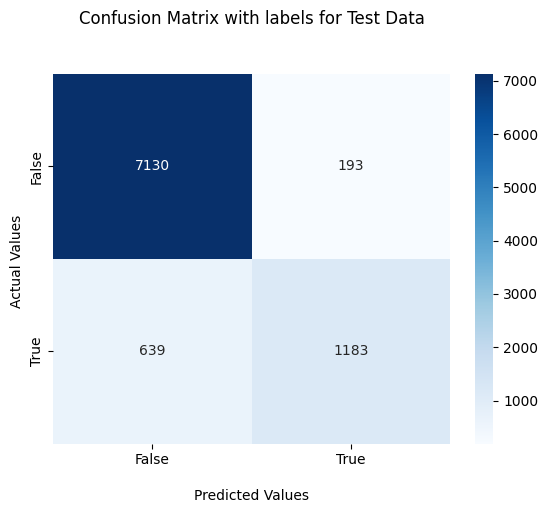

In [49]:
#Generate the confusion matrix for test set
cf_matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix with labels for Test Data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### XGB
### Tuned > baseline  (Precision)
<h3> Summary: </h3>
<ul> 
<li>This is because XGB has Area under the PR curve (aucpr) as the eval_metric to control the precision-recall trade off. </li>
<li>Tuned XGB: (85% prec vs 65% recall)</li>
</ul>

## 4.3 Testing Model Robustness With Jitter 

<h4> Tuned LGBM: 83% precision & 61% recall </h4>
<h4> Tuned XGB: 85% precision & 65% recall </h4>

<h3> Summary: </h3>
<ul> 
<li>This is to ensure our model continue to work in the future with consistency performance</li>
</ul>

In [50]:
def jitter(X, scale=0.1):
    return X + np.random.normal(0, scale, X.shape)

def jitter_test(classifier, X, y, scales = np.linspace(0, 0.5, 30), N = 5):
    out = []
    for s in scales:
        avg = 0.0
        for r in range(N):
            avg += f1_score(y, classifier.predict(jitter(X, s)))
        out.append(avg / N)
    return out, scales

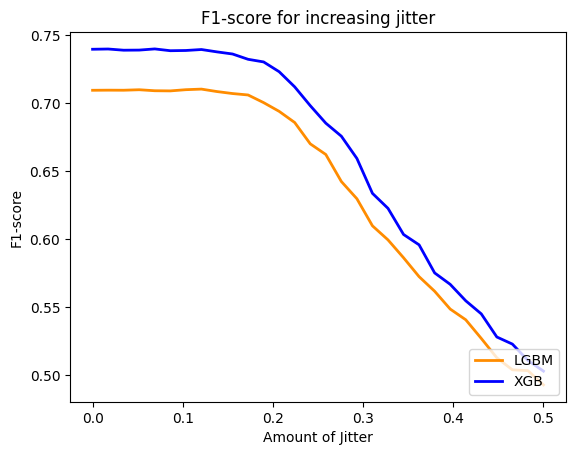

In [79]:
lgbm_scores, jitters = jitter_test(lgbm_clf_tuned, X_test, y_test)
xgb_scores, jitters = jitter_test(xgb_clf_tuned, X_test, y_test)

plt.figure()
lw = 2
plt.plot(jitters, lgbm_scores, color='darkorange',
         lw=lw, label='LGBM')
plt.plot(jitters, xgb_scores, color='blue',
         lw=lw, label='XGB')
plt.xlabel('Amount of Jitter')
plt.ylabel('F1-score')
plt.title('F1-score for increasing jitter')
plt.legend(loc="lower right")
plt.show()

## 4.4 Model Analysis

<h2 align="left"> Model Selection </h2>


<h2> Findings: </h2>
<ul>
<li> Both tuned XGB and tuned LGBM models have the similar degree of robustness. </li>
<li> But XGB model showed slightly better performance in general (auc, precision and recall) compared to LGBM. </li>
<li> Tuned xgb: AUC (0.92) Precision (0.83) Recall (0.65). </li>
<li> The optimal model will be <b>tuned xgb</b>. </li>
</ul>


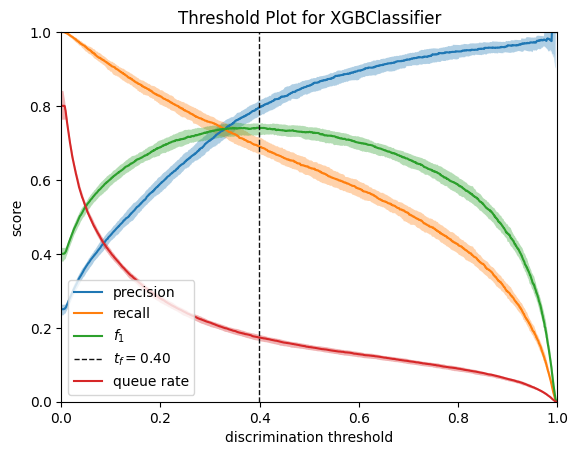

<AxesSubplot:title={'center':'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [80]:
visualizer = DiscriminationThreshold(xgb_clf_tuned)

visualizer.fit(X_train, y_train)    # Fit the data to the visualizer
visualizer.show()

**Note:** Visualize the precision-recall trade off

### Feature Importance

<Figure size 1800x1600 with 0 Axes>

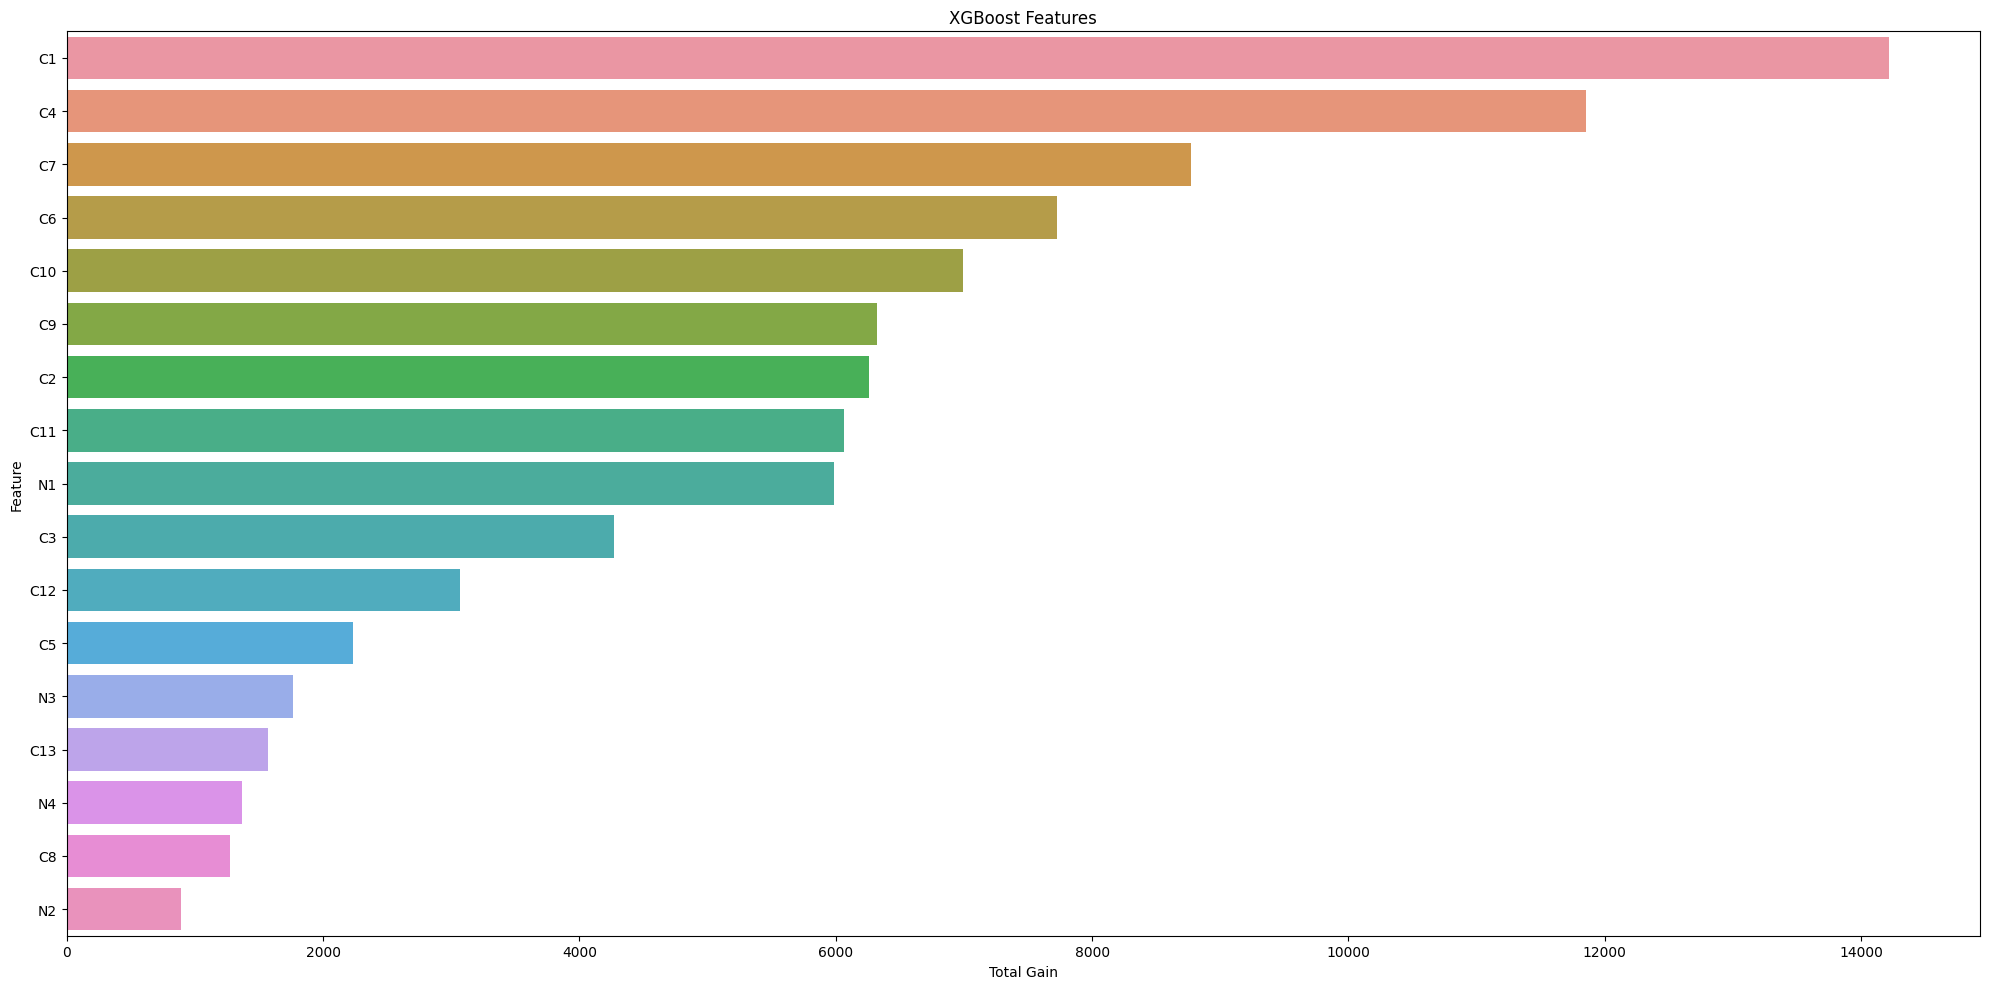

In [81]:
figure(figsize=(18, 16), dpi=100)
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(np.array(list(xgb_clf_tuned._Booster.get_score(importance_type='total_gain').values())),X_train.columns)), columns=['Total Gain','Feature'])
#gain = average gain for each split among all the trees
feature_imp = feature_imp.sort_values(by=['Total Gain'], ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x="Total Gain", y="Feature", data=feature_imp.sort_values(by="Total Gain", ascending=False))
plt.title('XGBoost Features')
plt.tight_layout()
plt.show()

In [82]:
import shap
# Fits the explainer
explainer = shap.Explainer(xgb_clf_tuned.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 9146it [10:10, 14.78it/s]                                                                       


<h2 align="left"> In-depth analysis </h2>

<h2> Findings: </h2>
<ul>
<li> We can see how higher and lower values of the feature will affect the result. </li>
<li> The horizontal axis represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations.</li>
<li> In this example, higher C4 and C11 values have a negative impact on the prediction, while lower values have a positive impact. </li>
</ul>


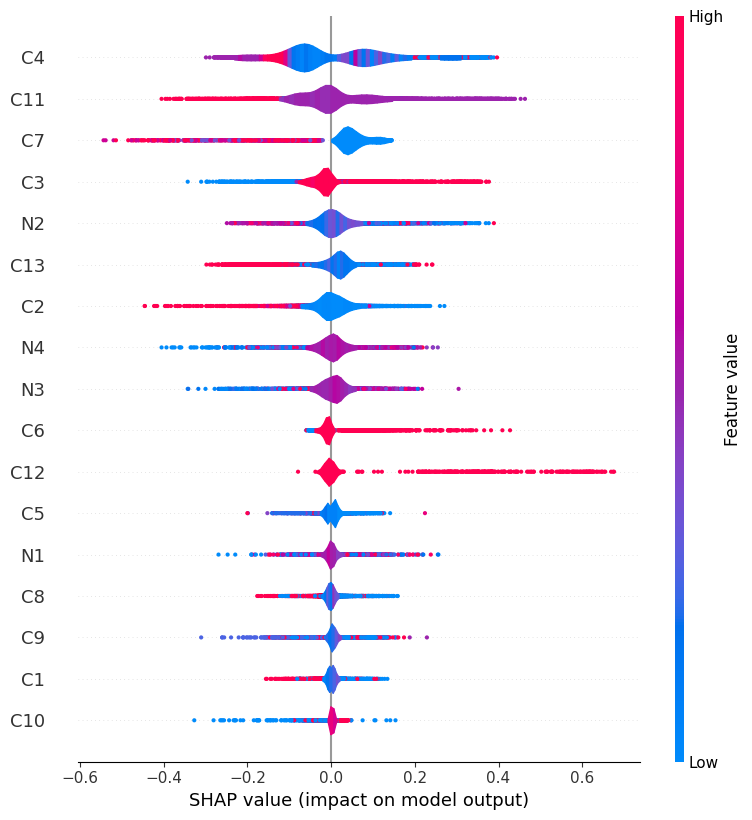

In [83]:
shap.summary_plot(shap_values, plot_type='violin')